## Comparisons

This code can execute the following three variants of losses:  

1. **Variant 1:**  Purely Physics  
   $L_{\theta} = L_{\text{PDE}}$  
   Use $n_{\text{used}} = 0$  

2. **Variant 2:**  Physics + Data  
   $L_{\theta} = L_{\text{PDE}} + \Sigma_{i=1}^{n_{\text{used}}}\| u_i - \hat{u}_i \|_2^2$  
   Use $n_{\text{used}} \in (0, 1000]$  

All the results presented were obtained as follows:
1. By estimating the gradients in the physics-informed loss terms using forward mode automatic differentiation (AD).
2. The output field values at given grid points were computed in one forward pass of the network using the einsum function.

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
import torch.distributions as td
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import argparse
import random
import os
import time 

import sys
sys.path.append("../..")
from utils.networks import *
from utils.deeponet_networks_1d import *
from utils.visualizer_misc import *
from utils.visualizer_1d import *
from utils.forward_autodiff import *
from utils.misc import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed = 0 # Seed number.
n_used = 0 # Number of full training fields used for estimating the data-driven loss term
save = False # Save results.

In [3]:
if save == True:
    resultdir = os.path.join(os.getcwd(),'results','ForwardAD_neval_c','a_Vanilla-NO_ForwardADeinsum') 
    if not os.path.exists(resultdir):
        os.makedirs(resultdir)
else:
    resultdir = None

In [4]:
set_seed(seed)

seed = 0


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# Load the data
data = np.load(os.path.join('..','..','data/1D_Diffusion-reaction_dynamics_t=0to1/Diffusion-reaction_dynamics.npz')) # Load the .npz file
print(data)
print(data['t_span'].shape)
print(data['x_span'].shape)
print(data['input_s_samples'].shape) # Random Source fields: Gaussian random fields, Nsamples x 100, each sample is (1 x 100)
print(data['output_u_samples'].shape) # Time evolution of the solution field: Nsamples x 101 x 100.
                               # Each field is 101 x 100, rows correspond to time and columns respond to location.
                               # First row corresponds to solution at t=0 (1st time step)
                               # and next  row corresponds to solution at t=0.01 (2nd time step) and so on.
                               # last row correspond to solution at t=1 (101th time step).

NpzFile '../../data/1D_Diffusion-reaction_dynamics_t=0to1/Diffusion-reaction_dynamics.npz' with keys: input_s_samples, output_u_samples, t_span, x_span
(101,)
(100,)
(2500, 100)
(2500, 101, 100)


In [7]:
# Convert NumPy arrays to PyTorch tensors
inputs = torch.from_numpy(data['input_s_samples'][0:1500]).float().to(device)
outputs = torch.from_numpy(data['output_u_samples'][0:1500]).float().to(device)

t_span = torch.from_numpy(data['t_span']).float().to(device)
x_span = torch.from_numpy(data['x_span']).float().to(device)
nt, nx = len(t_span), len(x_span) # number of discretizations in time and location.
print("nt =",nt, ", nx =",nx)
print("Shape of t-span and x-span:",t_span.shape, x_span.shape)
print("t-span:", t_span)
print("x-span:", x_span)

# Estimating grid points
T, X = torch.meshgrid(t_span, x_span)
# print(T)
# print(X)
grid = torch.vstack((T.flatten(), X.flatten())).T
print("Shape of grid:", grid.shape) # (nt*nx, 2)
print("grid:", grid) # time, location

# Split the data into training and testing samples
inputs_train, inputs_test, outputs_train, outputs_test = train_test_split(inputs, outputs, test_size=500, random_state=seed)

# Check the shapes of the subsets
print("Shape of inputs_train:", inputs_train.shape)
print("Shape of inputs_test:", inputs_test.shape)
print("Shape of outputs_train:", outputs_train.shape)
print("Shape of outputs_test:", outputs_test.shape)
print('#'*100)

nt = 101 , nx = 100
Shape of t-span and x-span: torch.Size([101]) torch.Size([100])
t-span: tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
        0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
        0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
        0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
        0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
        0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
        0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
        0.9900, 1.0000], dev

In [8]:
# Of these full training fields available I am using only n_used fields for estimating the data-driven loss term in the PI-Latent-NO
inputs_train_used = inputs_train[:n_used, :]
print("Shape of inputs_train_used:", inputs_train_used.shape)
outputs_train_used = outputs_train[:n_used, :, :]
print("Shape of outputs_train_used:", outputs_train_used.shape)

Shape of inputs_train_used: torch.Size([0, 100])
Shape of outputs_train_used: torch.Size([0, 101, 100])


In [9]:
"""
input_neurons_branch: Number of input neurons in the branch net.
input_neurons_trunk: Number of input neurons in the trunk net.
p: Number of output neurons in both the branch and trunk net.
"""
p = 128 # Number of output neurons in both the branch and trunk net.

input_neurons_branch = nx # m
branch_net = DenseNet(layersizes=[input_neurons_branch] + [64]*3 + [p], activation=nn.SiLU()) #nn.LeakyReLU() #nn.Tanh()
branch_net.to(device)
# print(branch_net)
print('BRANCH-NET SUMMARY:')
summary(branch_net, input_size=(input_neurons_branch,))  
print('#'*100)

input_neurons_trunk = 2 # 2 corresponds to t and x
trunk_net = DenseNet(layersizes=[input_neurons_trunk] + [64]*3 + [p], activation=nn.SiLU()) #nn.LeakyReLU() #nn.Tanh()
trunk_net.to(device)
# print(trunk_net)
print('TRUNK-NET SUMMARY:')
summary(trunk_net, input_size=(input_neurons_trunk,))
print('#'*100)

model = Vanilla_NO_model(branch_net, trunk_net)
model.to(device);

BRANCH-NET SUMMARY:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           6,464
              SiLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
              SiLU-4                   [-1, 64]               0
            Linear-5                   [-1, 64]           4,160
              SiLU-6                   [-1, 64]               0
            Linear-7                  [-1, 128]           8,320
Total params: 23,104
Trainable params: 23,104
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.09
Estimated Total Size (MB): 0.09
----------------------------------------------------------------
########################################################################################

In [10]:
num_learnable_parameters = count_learnable_parameters(branch_net) + count_learnable_parameters(trunk_net)
print("Total number of learnable parameters:", num_learnable_parameters)

Total number of learnable parameters: 39936


In [11]:
def loss_pde_residual(net, source_fields, t, x):
    
    u = net(source_fields, torch.hstack([t, x])) # u is (bs, neval_c)
    
    # Using forward automatic differention to estimate derivatives in the physics informed loss
    tangent_t, tangent_x = torch.ones(t.shape).to(device), torch.ones(x.shape).to(device)
    ut  = FWDAD_first_order_derivative(lambda t: net(source_fields, torch.hstack([t, x])), t, tangent_t) # (bs, neval_c)
    uxx = FWDAD_second_order_derivative(lambda x: net(source_fields, torch.hstack([t, x])), x, tangent_x) # (bs, neval_c)
    
    bs_ = source_fields.shape[0]
    sf_values_ = torch.zeros((bs_, x.shape[0], 1)).to(device)
    for j in range(bs_):
        sf_values_[j] = linear_interpolation_1D(x, x_span, source_fields[j]) # source function: s(x) values
    sf_values = sf_values_.reshape(-1, x.shape[0]) # (bs, neval_c)
    
    pde_residual = (ut - (0.01*uxx) - (0.01*(u**2)) - sf_values)**2
    
    return torch.mean(pde_residual)

In [12]:
def loss_pde_bcs(net, source_fields, t, x):
    
    t_b1, x_b1 = t[0], x[0]
    t_b2, x_b2 = t[1], x[1]

    u_b1 = net(source_fields, torch.hstack([t_b1, x_b1])) # u is (bs, neval_b)
    u_b2 = net(source_fields, torch.hstack([t_b2, x_b2])) # u is (bs, neval_b)

    bc1_value, bc2_value = 0., 0.
    pde_bc1 = (u_b1 - bc1_value)**2
    pde_bc2 = (u_b2 - bc2_value)**2
    
    return torch.mean(pde_bc1) + torch.mean(pde_bc2)

In [13]:
def loss_pde_ic(net, source_fields, t, x):
    
    u_ic = net(source_fields, torch.hstack([t, x])) # u is (bs, neval_i)
    
    ic_value = 0.
    pde_ic = (u_ic - ic_value)**2
    
    return torch.mean(pde_ic)

In [14]:
def collocation_points(tc_span, xc_span, neval_dict):
    tc = tc_span.repeat_interleave(neval_dict['loc']).unsqueeze(-1)
    xc = xc_span.flatten().repeat(neval_dict['t']).unsqueeze(-1)
    return tc, xc

In [15]:
neval_t = 256  # Number of time points at which output field is evaluated.
neval_x = 256 
# neval_loc = neval_x  # Number of locations at which output field is evaluated at each time point.

In [16]:
# Parameters
neval_t = 16
neval_x = 16


neval_t = 16, neval_x = 16


Iteration 0 - loss = 0.988456, data-driven loss = 0.000000, pinn loss = 0.988456, learning rate = 0.003500, test loss = 0.275924


Iteration 100 - loss = 0.496453, data-driven loss = 0.000000, pinn loss = 0.496453, learning rate = 0.003500, test loss = 0.159712


Iteration 200 - loss = 0.498112, data-driven loss = 0.000000, pinn loss = 0.498112, learning rate = 0.003500, test loss = 0.107027


Iteration 300 - loss = 0.351565, data-driven loss = 0.000000, pinn loss = 0.351565, learning rate = 0.003500, test loss = 0.089606


Iteration 400 - loss = 0.331200, data-driven loss = 0.000000, pinn loss = 0.331200, learning rate = 0.003500, test loss = 0.074108


Iteration 500 - loss = 0.232723, data-driven loss = 0.000000, pinn loss = 0.232723, learning rate = 0.003500, test loss = 0.034186


Iteration 600 - loss = 0.178999, data-driven loss = 0.000000, pinn loss = 0.178999, learning rate = 0.003500, test loss = 0.016399


Iteration 700 - loss = 0.101518, data-driven loss = 0.000000, pinn loss = 0.101518, learning rate = 0.003500, test loss = 0.013045


Iteration 800 - loss = 0.152355, data-driven loss = 0.000000, pinn loss = 0.152355, learning rate = 0.003500, test loss = 0.010300


Iteration 900 - loss = 0.070724, data-driven loss = 0.000000, pinn loss = 0.070724, learning rate = 0.003500, test loss = 0.005940


Memory used: 747.00 MB


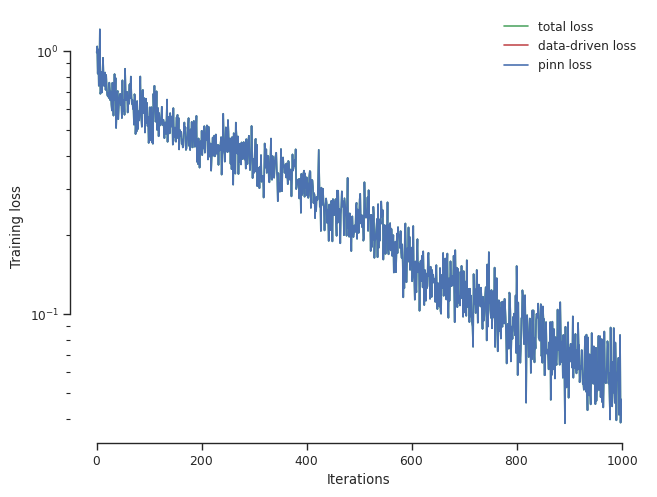

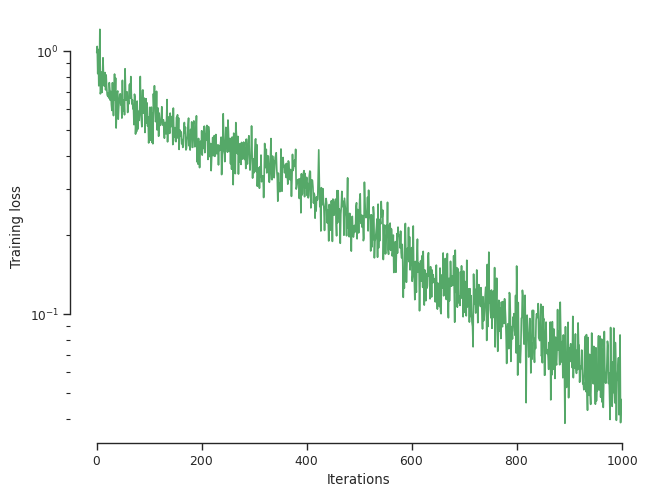

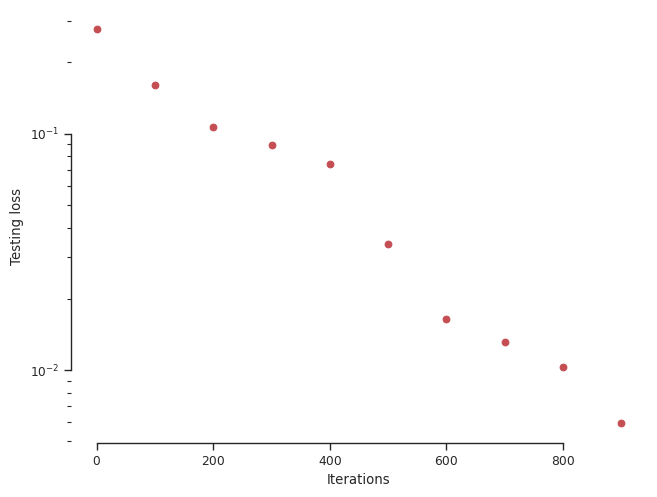

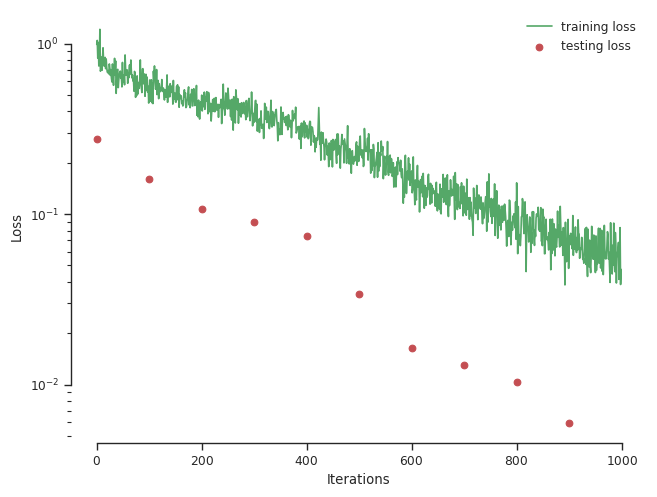

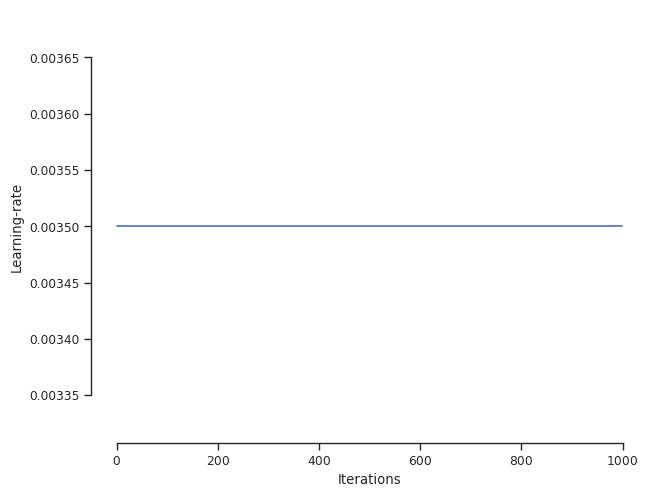

In [17]:
start_time = time.time()

bs = 64 # Batch size

print(f"neval_t = {neval_t}, neval_x = {neval_x}")

neval_c = {'t': neval_t, 'loc': neval_x}  # Number of collocation points within the domain.
neval_b = {'t': neval_t, 'loc': 1}        # Number of collocation points on each boundary.
neval_i = {'t': 1, 'loc': neval_x}        # Number of collocation points at t=0.
        
# Training
optimizer = torch.optim.Adam(model.parameters(), lr=3.5*1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15000, gamma=0.1) # gamma=0.8

iteration_list, loss_list, learningrates_list = [], [], []
datadriven_loss_list, pinn_loss_list = [], []
test_iteration_list, test_loss_list = [], []

n_iterations = 1000
for iteration in range(n_iterations):
    
    if n_used == 0:
        datadriven_loss = torch.tensor([0.]).to(device)
        # print('*********')
    else:
        indices_datadriven = torch.randperm(n_used).to(device) # Generate random permutation of indices
        inputs_train_used_batch = inputs_train_used[indices_datadriven[0:bs]]
        outputs_train_used_batch = outputs_train_used.reshape(-1, nt*nx)[indices_datadriven[0:bs]]
        # print(f"Shape of inputs_train_used_batch:", inputs_train_used_batch.shape) # (bs, nx)
        # print(f"Shape of outputs_train_used_batch:", outputs_train_used_batch.shape) # (bs, nt*nx)

        predicted_values = model(inputs_train_used_batch, grid)  # (bs, neval) = (bs, nt*nx)
        target_values = outputs_train_used_batch # (bs, nt*nx)
        datadriven_loss = nn.MSELoss()(predicted_values, target_values)
        # print('*********')
    
    # Shuffle the train data using the generated indices
    num_samples = len(inputs_train)
    indices_pinn = torch.randperm(num_samples).to(device) # Generate random permutation of indices
    inputs_batch = inputs_train[indices_pinn[0:bs]]
    #print(f"Shape of inputs_batch:", inputs_batch.shape) # (bs, nx)
        
    # points within the domain
    tc_span = td.uniform.Uniform(0., 1.).sample((neval_c['t'], 1)).to(device)
    xc_span = td.uniform.Uniform(0., 1.).sample((neval_c['loc'], 1)).to(device)
    tc, xc= collocation_points(tc_span, xc_span, neval_c)

    # boundary points on the 2 boundaries (hard-coded)
    tb = [td.uniform.Uniform(0., 1.).sample((neval_b['t'], 1)).to(device),
          td.uniform.Uniform(0., 1.).sample((neval_b['t'], 1)).to(device)]

    xb = [torch.full((neval_b['t'], 1), 0.).to(device),
          torch.full((neval_b['t'], 1), 1.).to(device)]

    # initial points
    ti = torch.full((neval_i['loc'], 1), 0.).to(device)
    xi = td.uniform.Uniform(0., 1.).sample((neval_i['loc'], 1)).to(device)
    
    pinn_loss = (loss_pde_residual(model, inputs_batch, tc, xc) 
           + loss_pde_bcs(model, inputs_batch, tb, xb) 
           + loss_pde_ic(model, inputs_batch, ti, xi))

    optimizer.zero_grad()
    loss = datadriven_loss + pinn_loss
    loss.backward()
    # torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()
    scheduler.step()

    if iteration % 100 == 0:
        # Test loss calculation
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            test_predicted_values = model(inputs_test, grid)  # (bs, neval) = (bs, nt*nx)
            test_loss = nn.MSELoss()(test_predicted_values, outputs_test.reshape(-1, nt*nx))
            test_iteration_list.append(iteration)
            test_loss_list.append(test_loss.item())  
        model.train()  # Switch back to training mode
        print('Iteration %s -' % iteration, 'loss = %f,' % loss,
              'data-driven loss = %f,' % datadriven_loss,'pinn loss = %f,' % pinn_loss,
              'learning rate = %f,' % optimizer.state_dict()['param_groups'][0]['lr'],
              'test loss = %f' % test_loss)

    iteration_list.append(iteration)
    loss_list.append(loss.item())
    datadriven_loss_list.append(datadriven_loss.item())
    pinn_loss_list.append(pinn_loss.item())
    learningrates_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

if device.type == "cuda":
    free, total = torch.cuda.mem_get_info()
    mem_used_MB = (total - free) / 1024 ** 2
    print(f"Memory used: {mem_used_MB:.2f} MB")

if save == True:
    np.save(os.path.join(resultdir,'iteration_list.npy'), np.asarray(iteration_list))
    np.save(os.path.join(resultdir,'loss_list.npy'), np.asarray(loss_list))
    np.save(os.path.join(resultdir, 'datadriven_loss_list.npy'), np.asarray(datadriven_loss_list))
    np.save(os.path.join(resultdir, 'pinn_loss_list.npy'), np.asarray(pinn_loss_list))
    np.save(os.path.join(resultdir,'learningrates_list.npy'), np.asarray(learningrates_list))
    np.save(os.path.join(resultdir,'test_iteration_list.npy'), np.asarray(test_iteration_list))
    np.save(os.path.join(resultdir, 'test_loss_list.npy'), np.asarray(test_loss_list)) 

plot_loss_terms(resultdir, iteration_list, loss_list, datadriven_loss_list, pinn_loss_list, save)  

plot_training_loss(resultdir, iteration_list, loss_list, save)

plot_testing_loss(resultdir, test_iteration_list, test_loss_list, save)

plot_training_testing_loss(resultdir, iteration_list, loss_list, test_iteration_list, test_loss_list, save)

plot_learningrates(resultdir, iteration_list, learningrates_list, save)
    
# end timer
end_time = time.time()
training_time = end_time - start_time # in sec
 
runtime_per_iter = training_time/n_iterations # in sec/iter

In [18]:
if save == True:
    torch.save(model.state_dict(), os.path.join(resultdir,'model_state_dict.pt'))
# model.load_state_dict(torch.load(os.path.join(resultdir,'model_state_dict.pt'), map_location=device))

TEST SAMPLE 10
Rel. L2 Error = 0.1298, R2 score = 0.9828


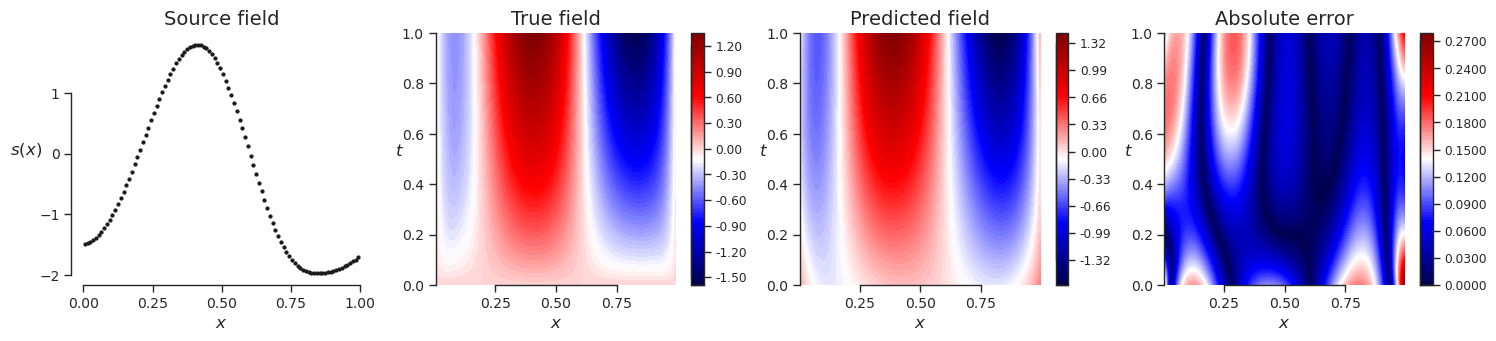

######################################################################################################################################################################################################################################
TEST SAMPLE 20
Rel. L2 Error = 0.112, R2 score = 0.978


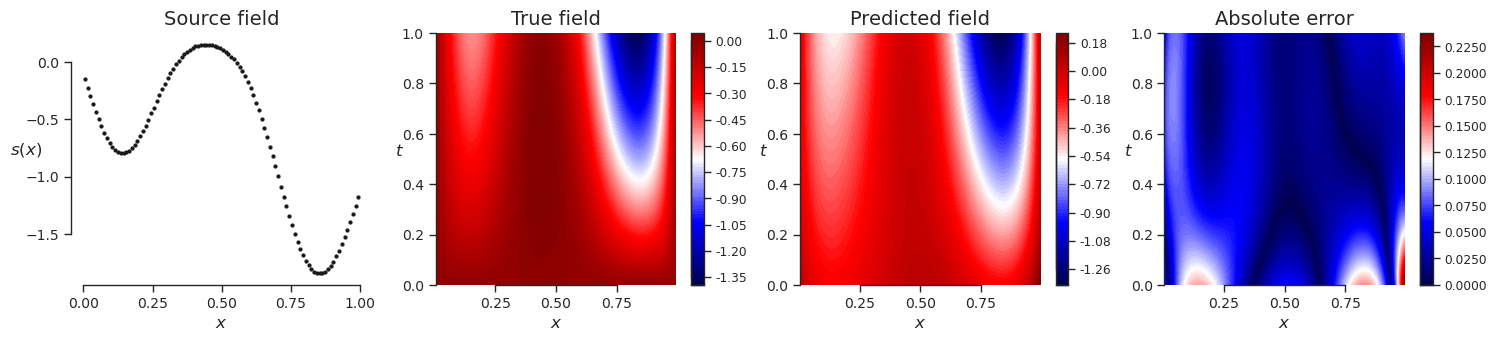

######################################################################################################################################################################################################################################
TEST SAMPLE 30
Rel. L2 Error = 0.1955, R2 score = 0.9494


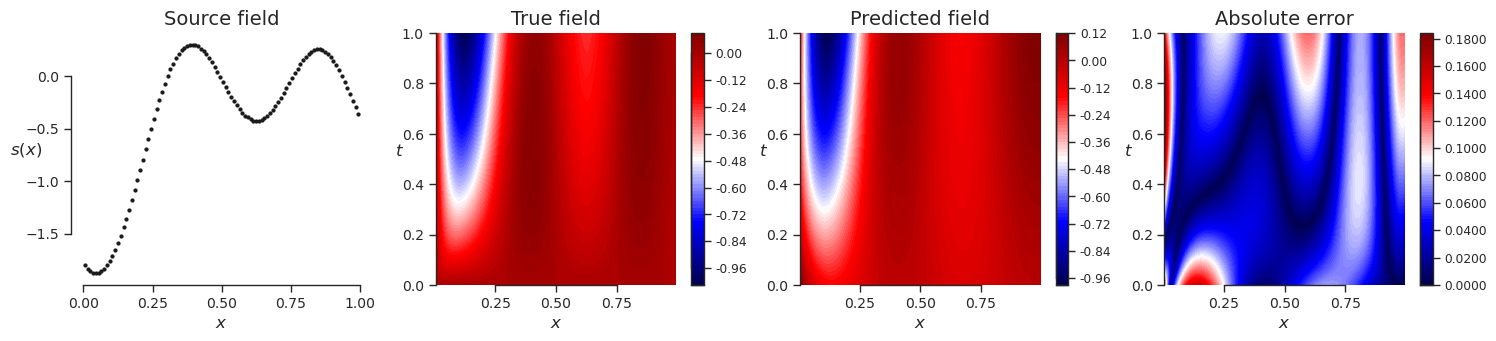

######################################################################################################################################################################################################################################
TEST SAMPLE 40
Rel. L2 Error = 0.0688, R2 score = 0.9867


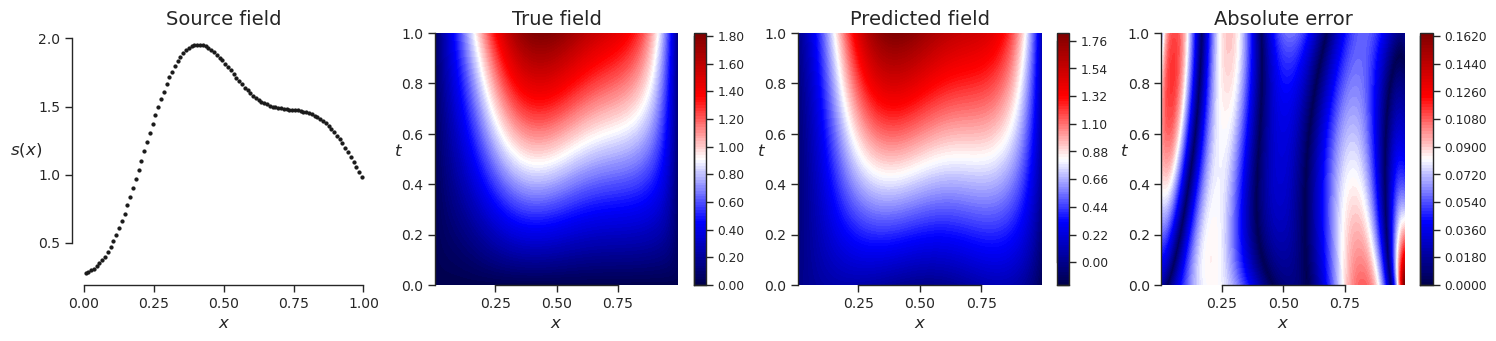

######################################################################################################################################################################################################################################
TEST SAMPLE 50
Rel. L2 Error = 0.1031, R2 score = 0.9645


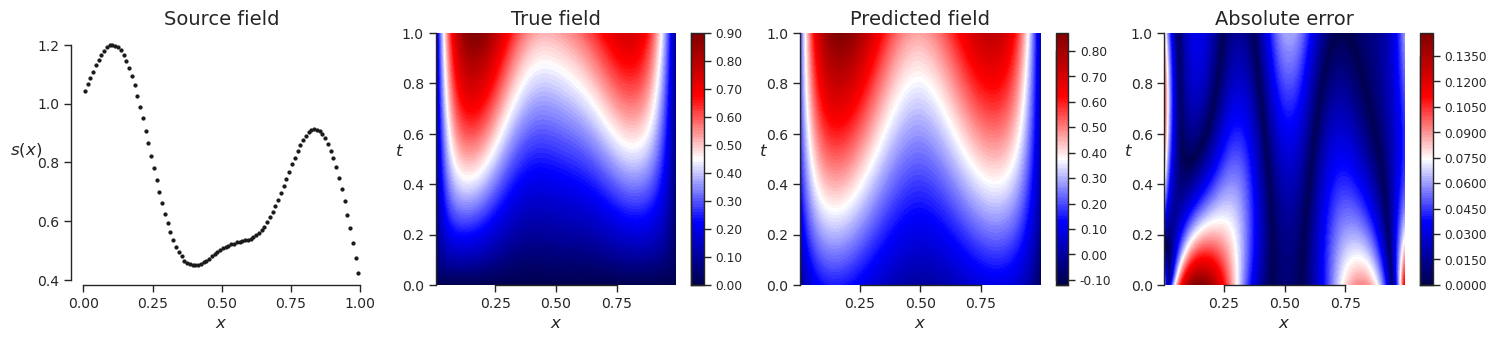

######################################################################################################################################################################################################################################
TEST SAMPLE 60
Rel. L2 Error = 0.1642, R2 score = 0.9627


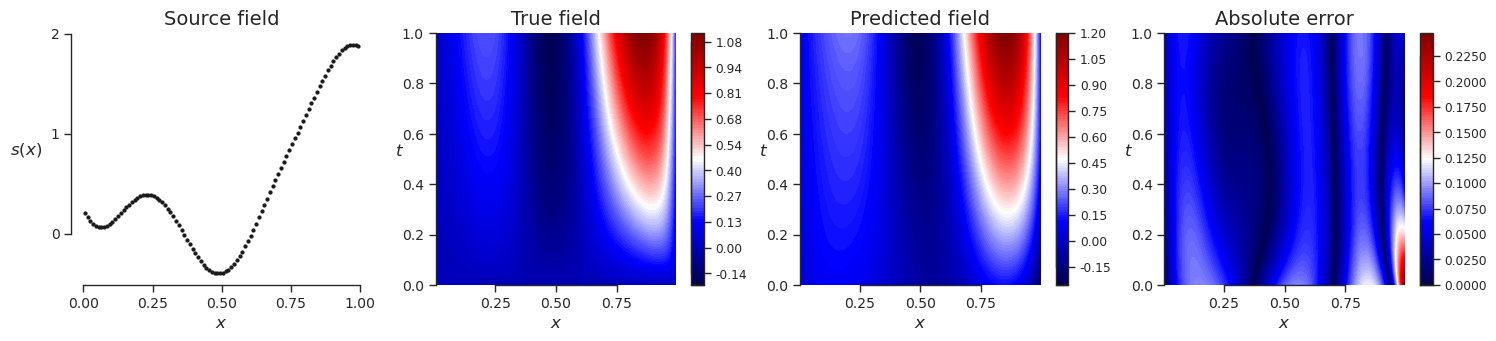

######################################################################################################################################################################################################################################
TEST SAMPLE 70
Rel. L2 Error = 0.1208, R2 score = 0.9846


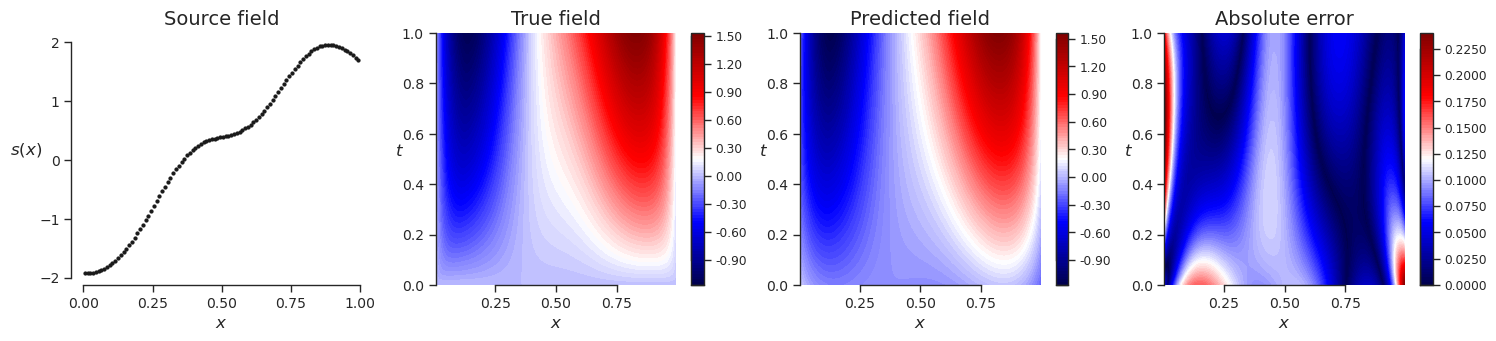

######################################################################################################################################################################################################################################
TEST SAMPLE 80
Rel. L2 Error = 0.0765, R2 score = 0.9883


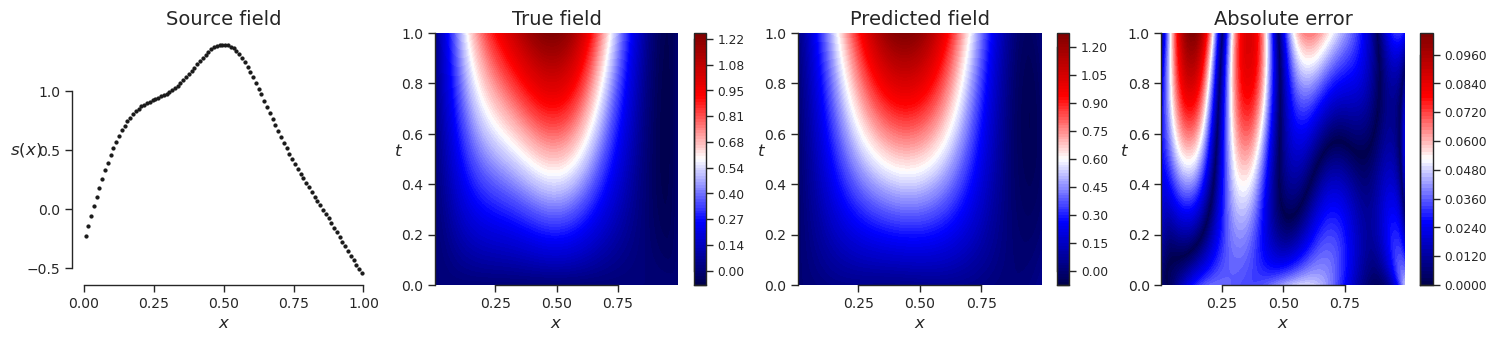

######################################################################################################################################################################################################################################
TEST SAMPLE 90
Rel. L2 Error = 0.1288, R2 score = 0.9771


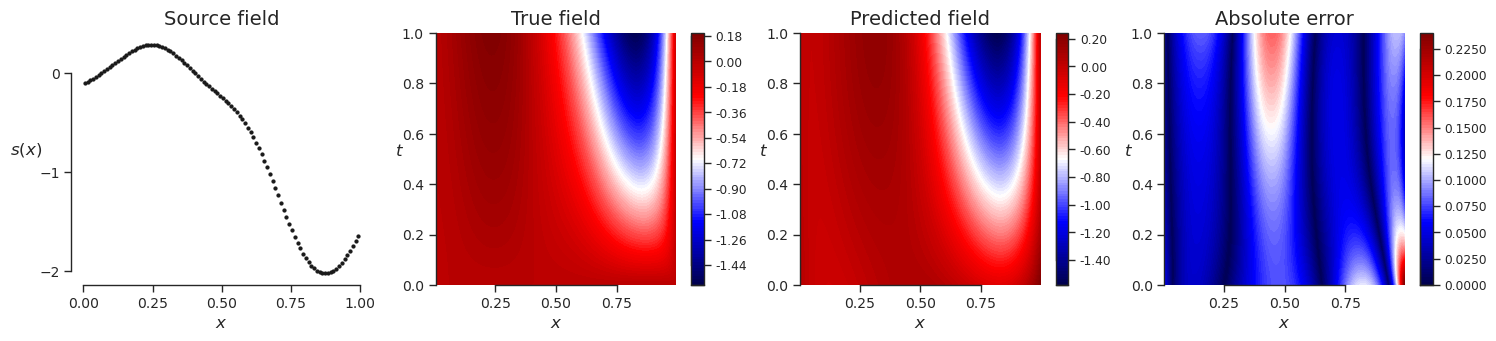

######################################################################################################################################################################################################################################
TEST SAMPLE 100
Rel. L2 Error = 0.2143, R2 score = 0.954


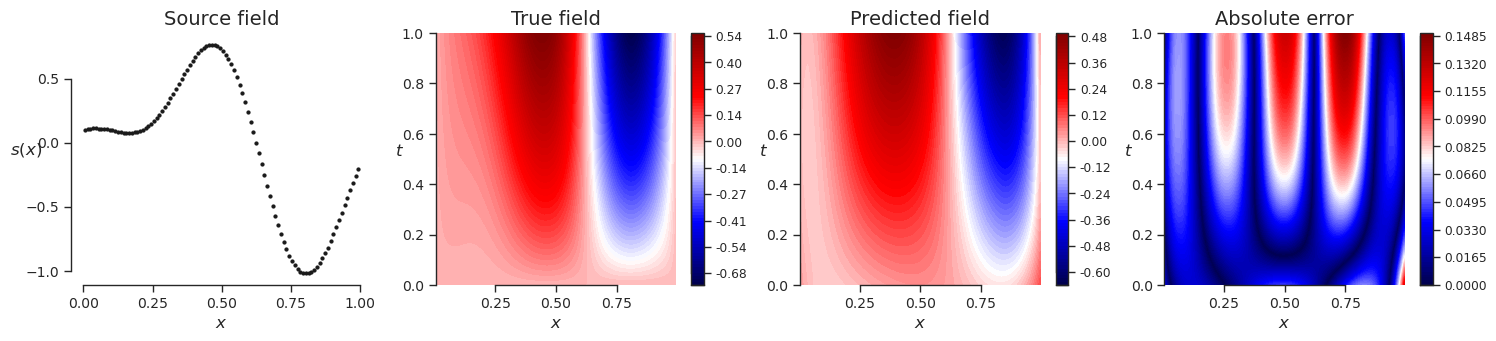

######################################################################################################################################################################################################################################
TEST SAMPLE 110
Rel. L2 Error = 0.1154, R2 score = 0.986


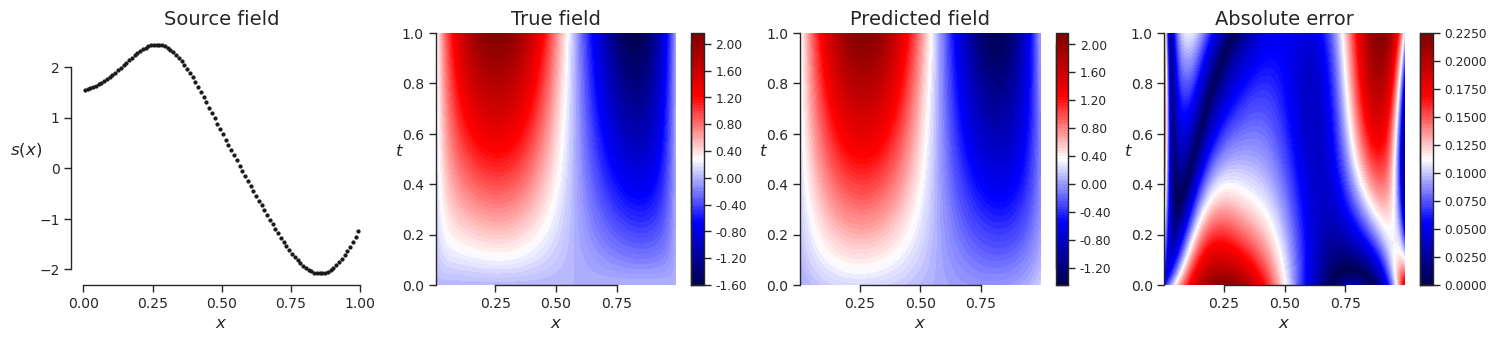

######################################################################################################################################################################################################################################
TEST SAMPLE 120
Rel. L2 Error = 0.0652, R2 score = 0.9875


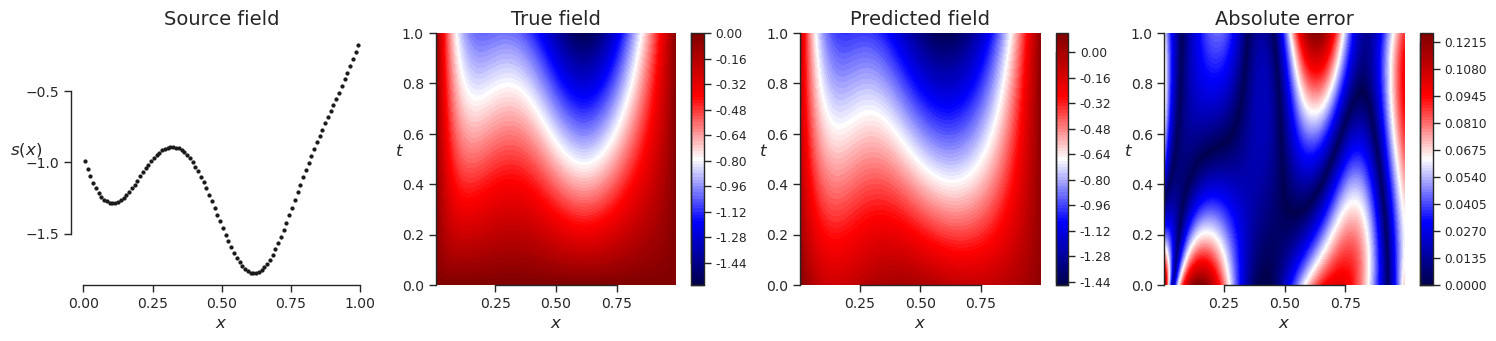

######################################################################################################################################################################################################################################
TEST SAMPLE 130
Rel. L2 Error = 0.1146, R2 score = 0.986


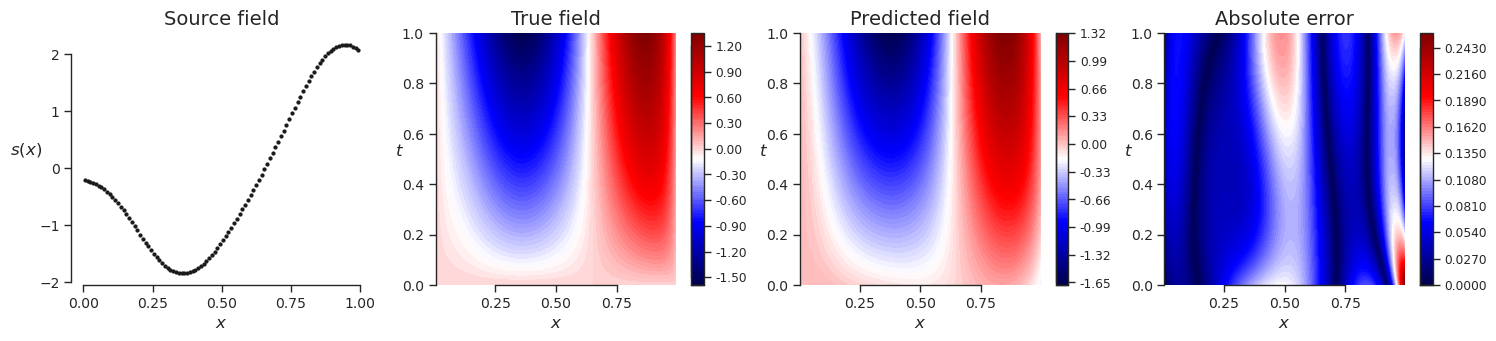

######################################################################################################################################################################################################################################
TEST SAMPLE 140
Rel. L2 Error = 0.0867, R2 score = 0.9906


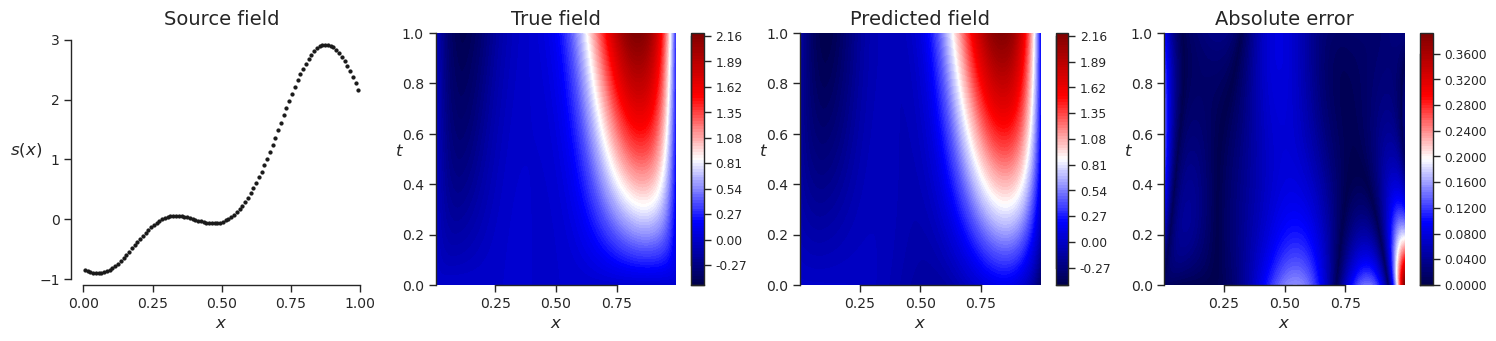

######################################################################################################################################################################################################################################
TEST SAMPLE 150
Rel. L2 Error = 0.1947, R2 score = 0.8596


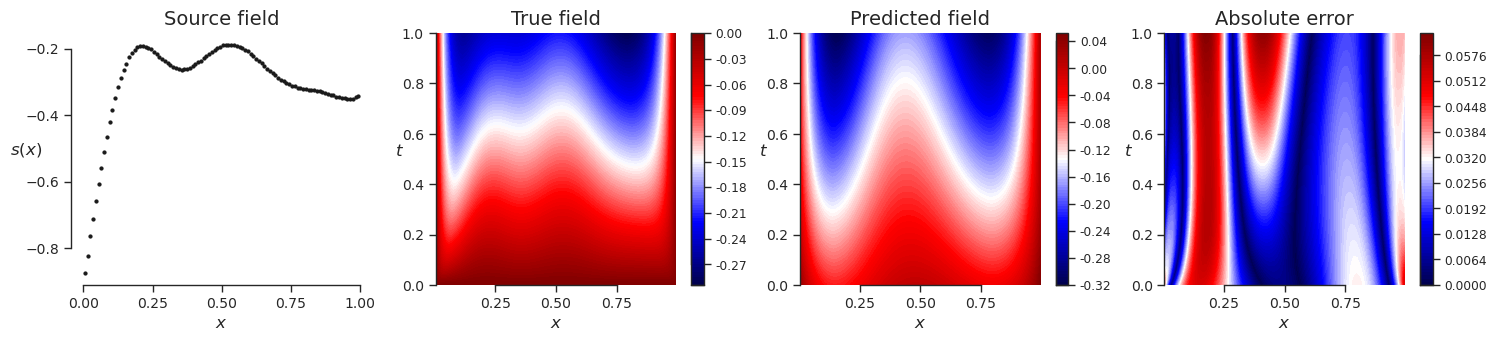

######################################################################################################################################################################################################################################
TEST SAMPLE 160
Rel. L2 Error = 0.2608, R2 score = 0.9158


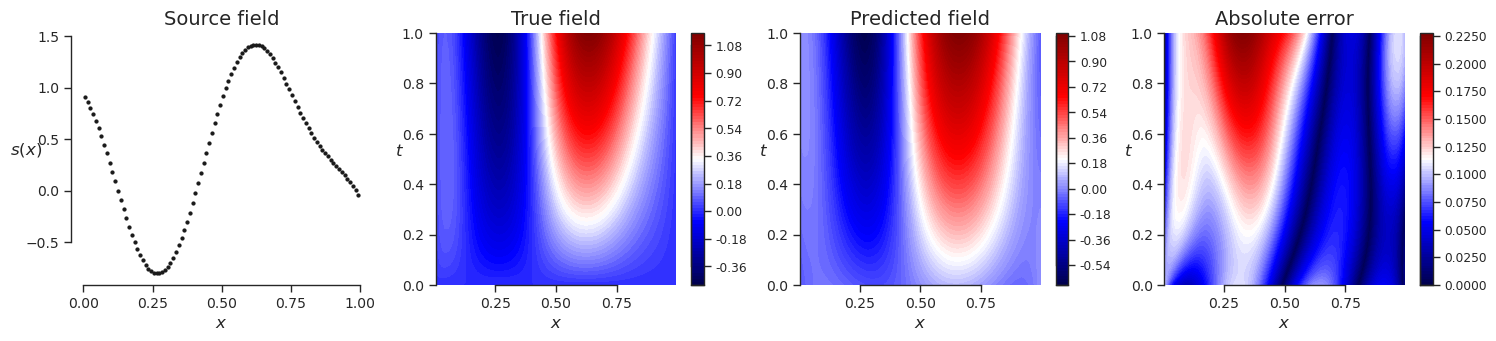

######################################################################################################################################################################################################################################
TEST SAMPLE 170
Rel. L2 Error = 0.1589, R2 score = 0.9561


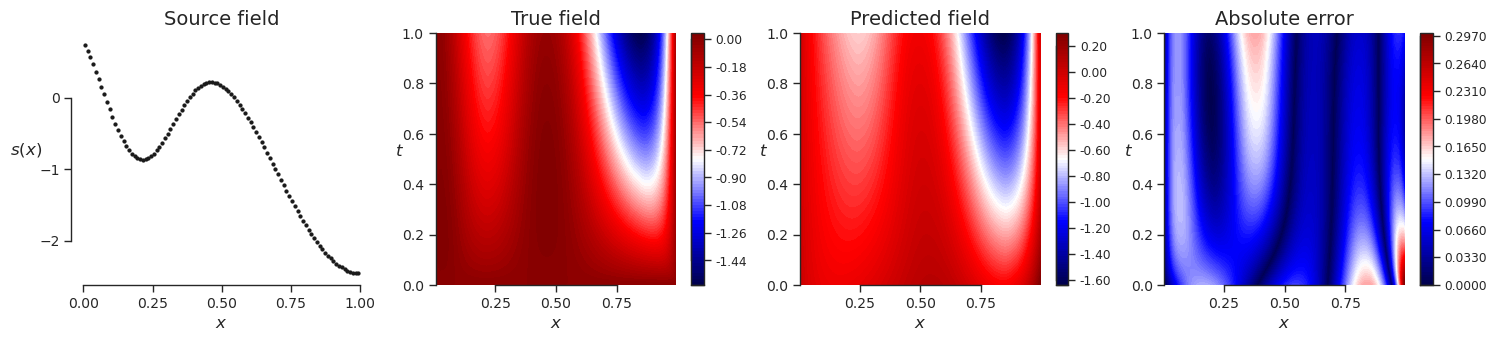

######################################################################################################################################################################################################################################
TEST SAMPLE 180
Rel. L2 Error = 0.101, R2 score = 0.9677


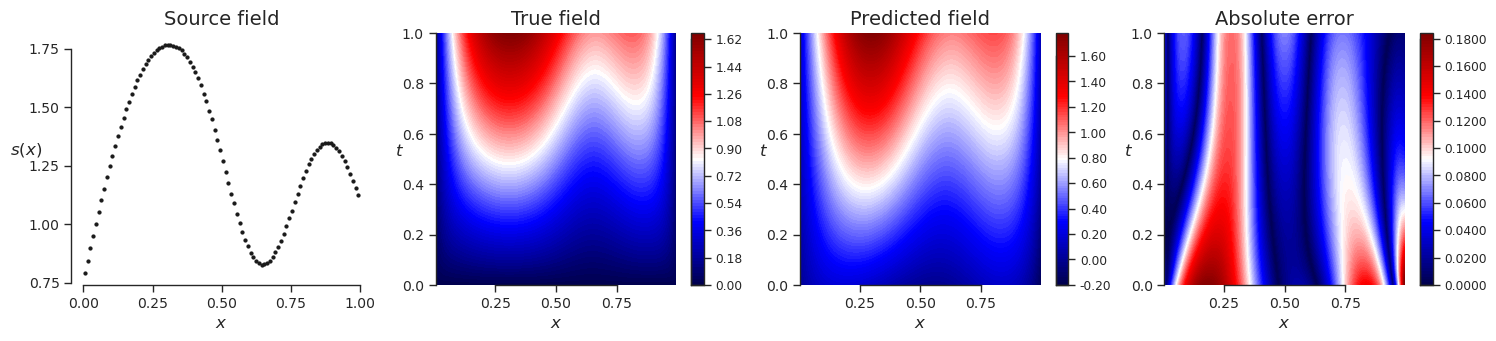

######################################################################################################################################################################################################################################
TEST SAMPLE 190
Rel. L2 Error = 0.3176, R2 score = 0.8629


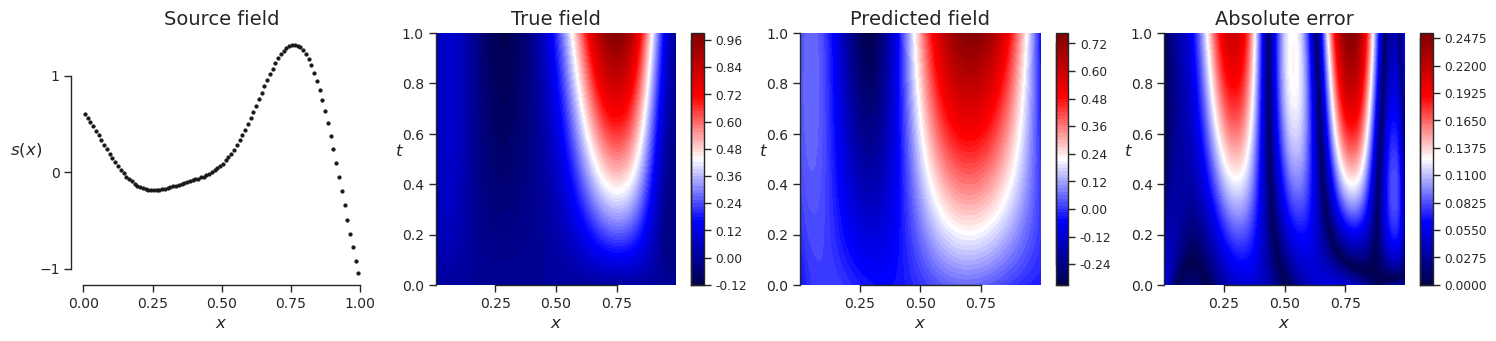

######################################################################################################################################################################################################################################
TEST SAMPLE 200
Rel. L2 Error = 0.1571, R2 score = 0.9577


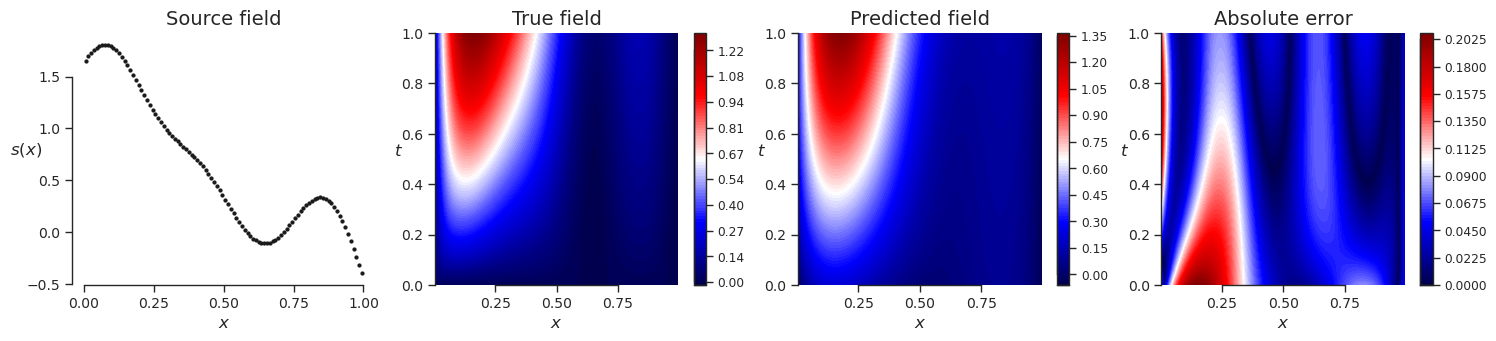

######################################################################################################################################################################################################################################
TEST SAMPLE 210
Rel. L2 Error = 0.2403, R2 score = 0.931


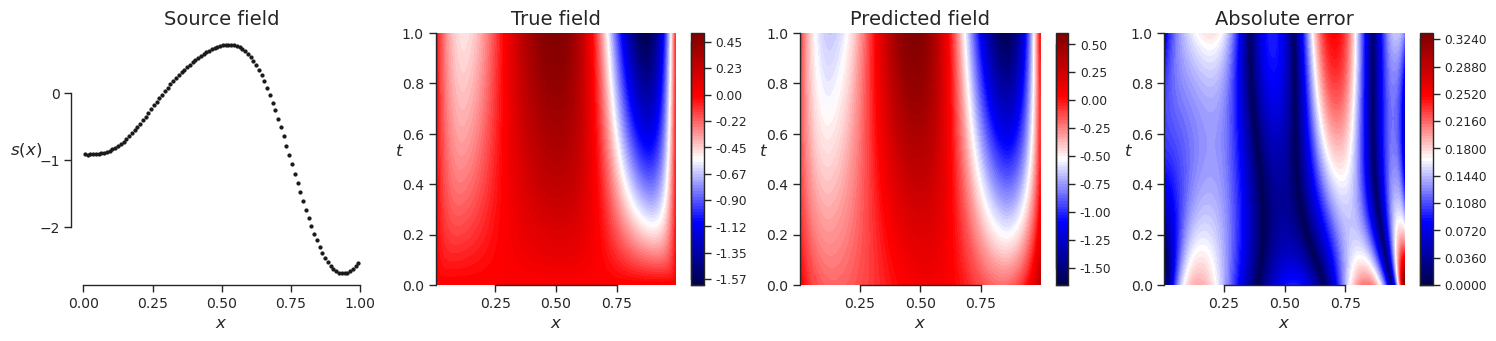

######################################################################################################################################################################################################################################
TEST SAMPLE 220
Rel. L2 Error = 0.1845, R2 score = 0.9334


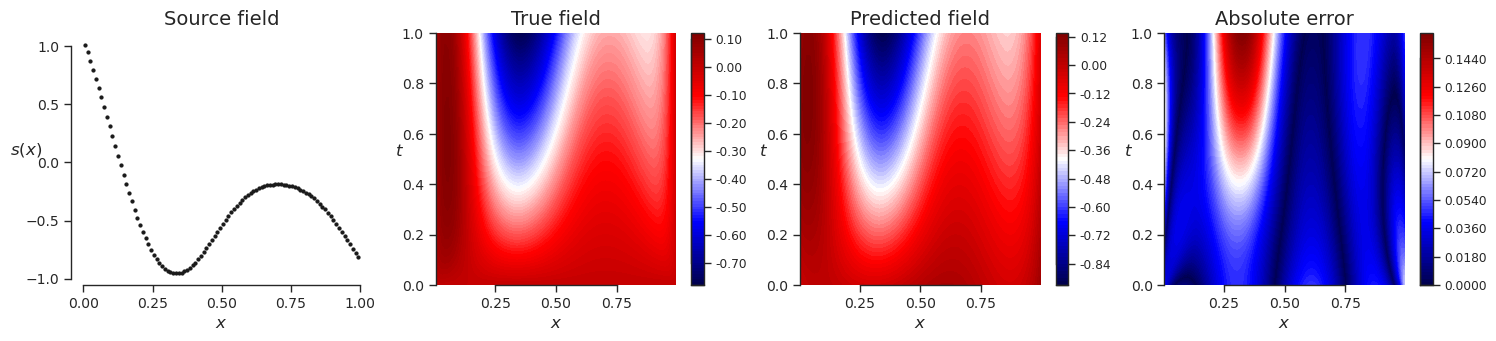

######################################################################################################################################################################################################################################
TEST SAMPLE 230
Rel. L2 Error = 0.1613, R2 score = 0.9704


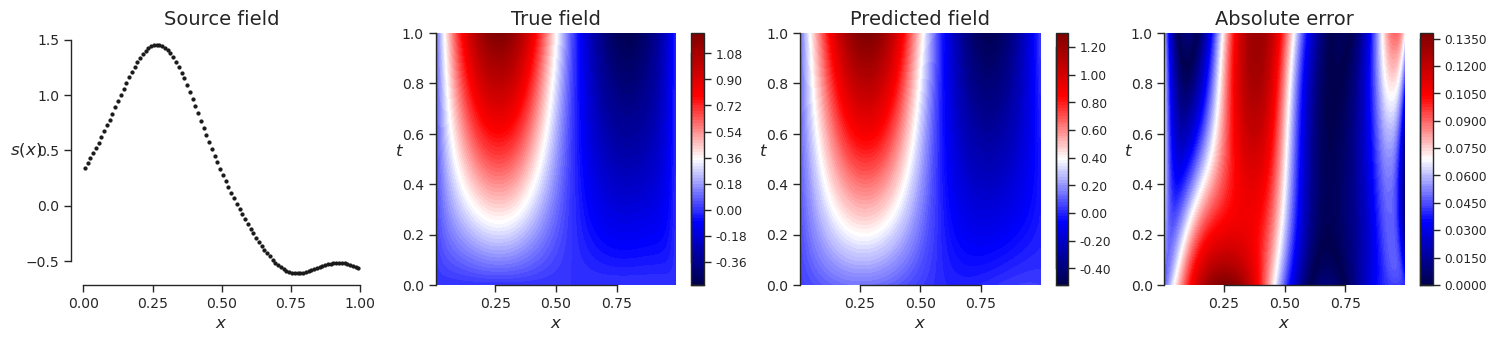

######################################################################################################################################################################################################################################
TEST SAMPLE 240
Rel. L2 Error = 0.0817, R2 score = 0.986


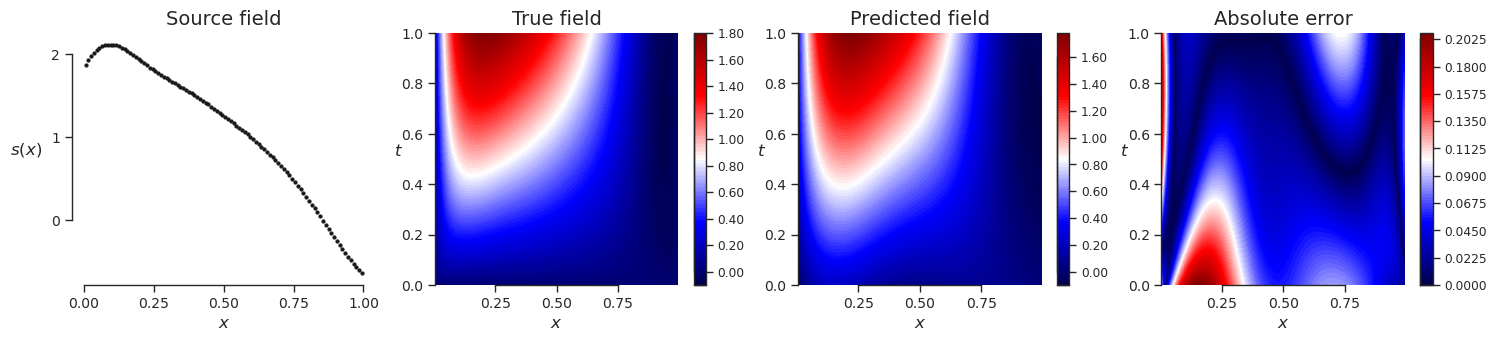

######################################################################################################################################################################################################################################
TEST SAMPLE 250
Rel. L2 Error = 0.1799, R2 score = 0.9667


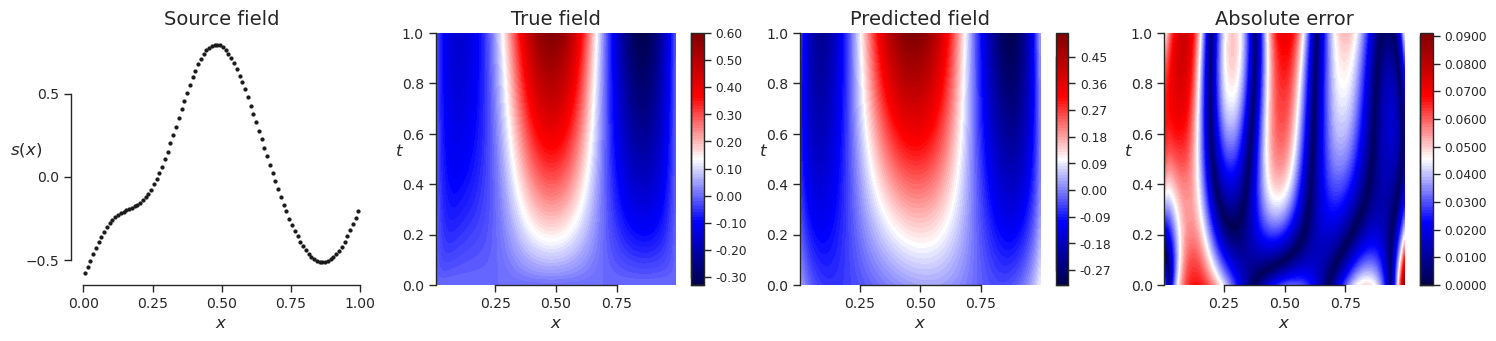

######################################################################################################################################################################################################################################
TEST SAMPLE 260
Rel. L2 Error = 0.1069, R2 score = 0.9867


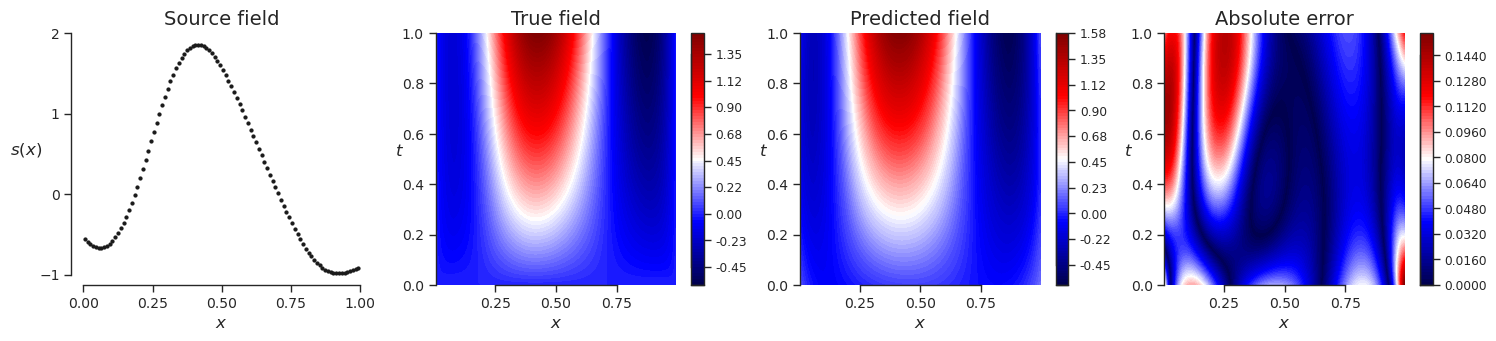

######################################################################################################################################################################################################################################
TEST SAMPLE 270
Rel. L2 Error = 0.0995, R2 score = 0.9693


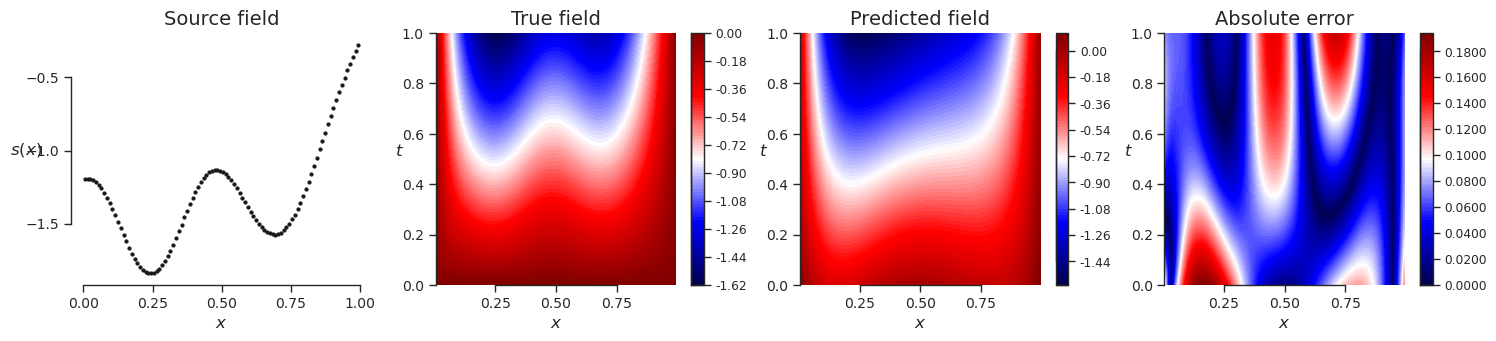

######################################################################################################################################################################################################################################
TEST SAMPLE 280
Rel. L2 Error = 0.2302, R2 score = 0.9439


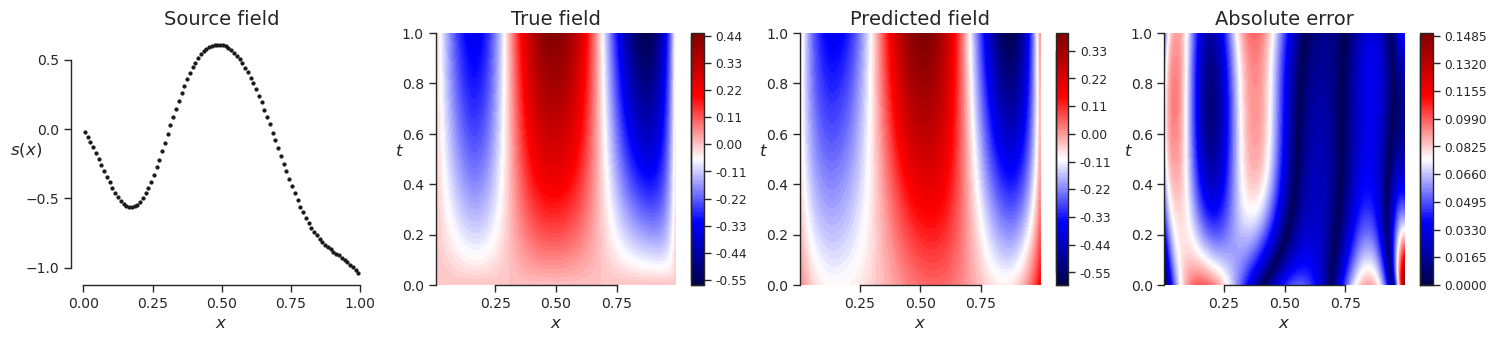

######################################################################################################################################################################################################################################
TEST SAMPLE 290
Rel. L2 Error = 0.3155, R2 score = 0.8923


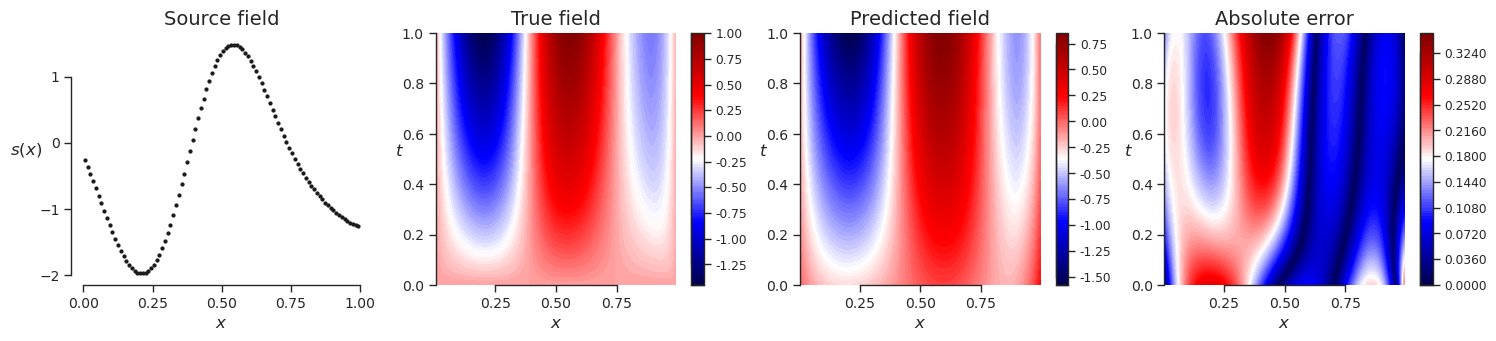

######################################################################################################################################################################################################################################
TEST SAMPLE 300
Rel. L2 Error = 0.2919, R2 score = 0.8994


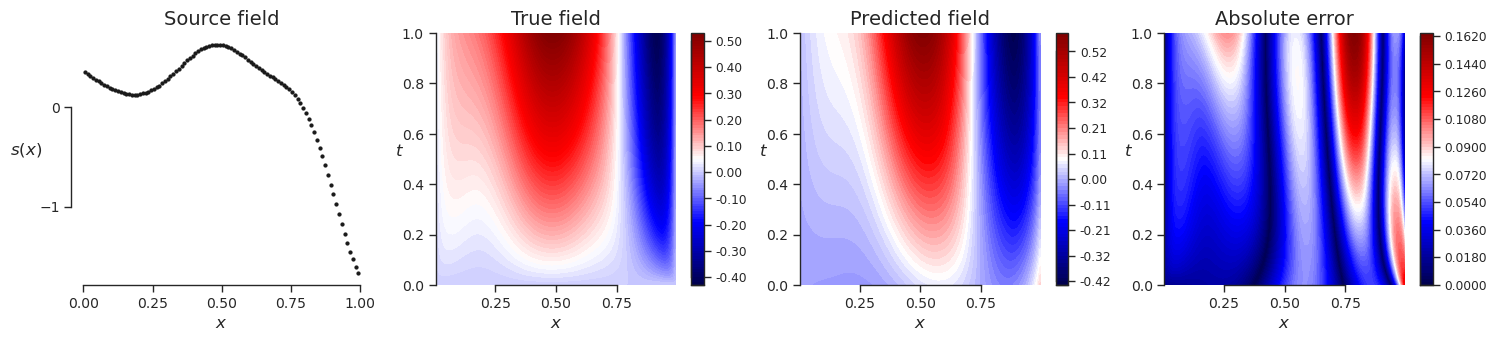

######################################################################################################################################################################################################################################
TEST SAMPLE 310
Rel. L2 Error = 0.0711, R2 score = 0.9881


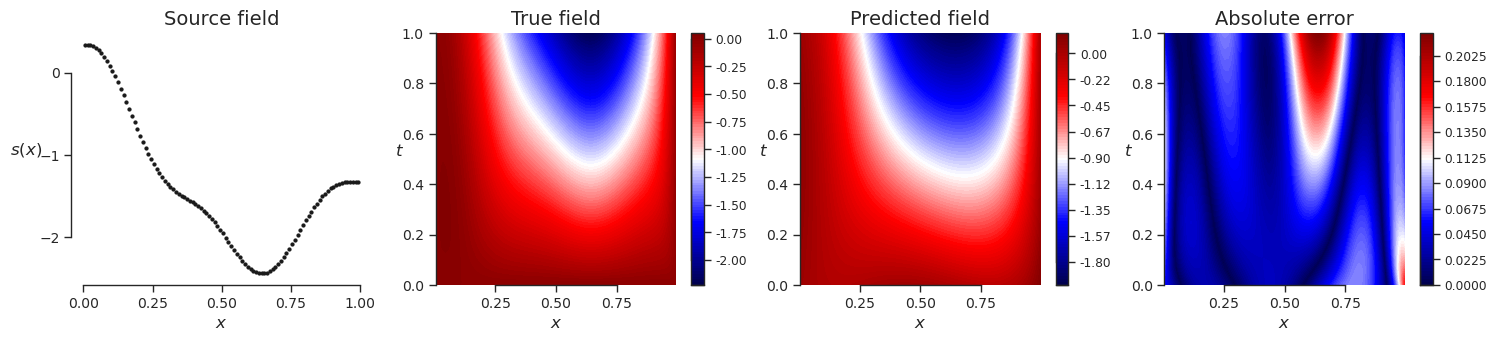

######################################################################################################################################################################################################################################
TEST SAMPLE 320
Rel. L2 Error = 0.162, R2 score = 0.9647


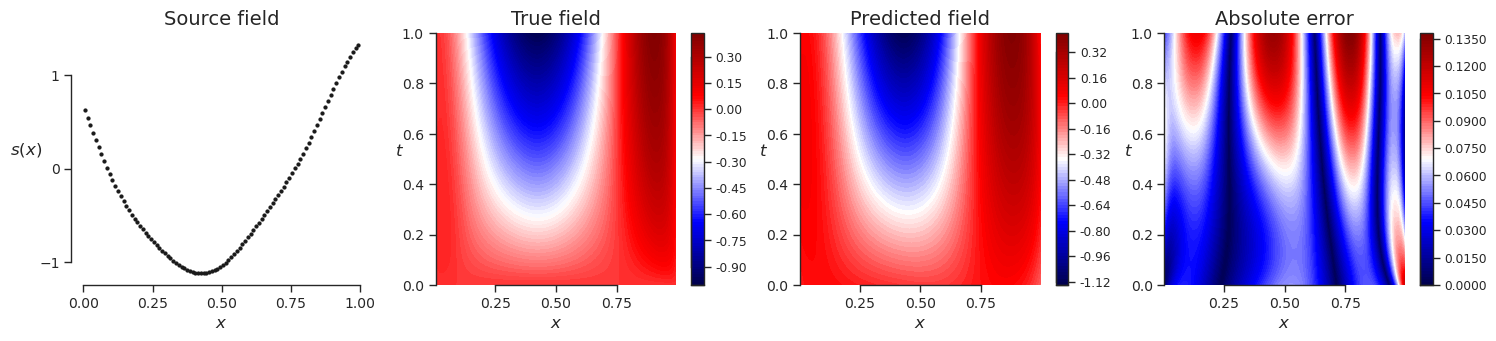

######################################################################################################################################################################################################################################
TEST SAMPLE 330
Rel. L2 Error = 0.1225, R2 score = 0.9696


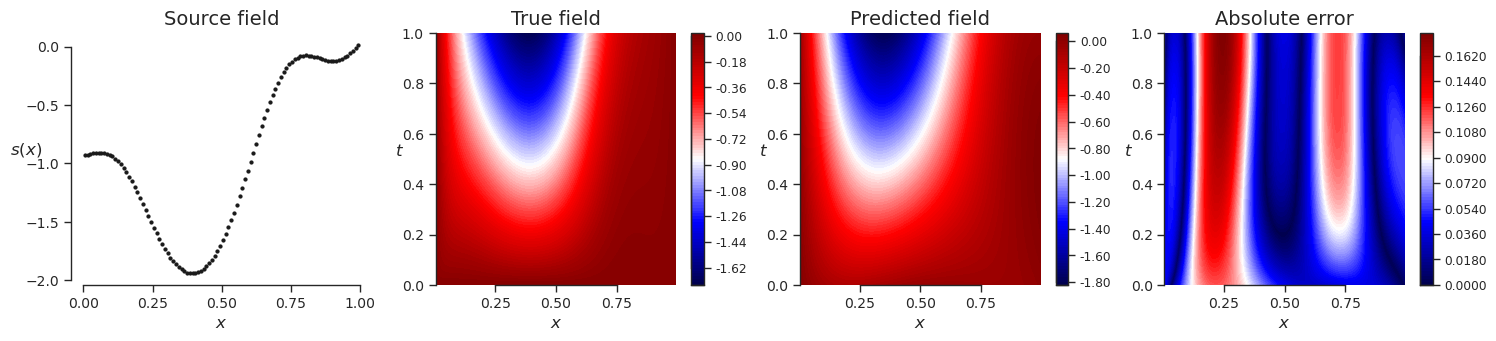

######################################################################################################################################################################################################################################
TEST SAMPLE 340
Rel. L2 Error = 0.1075, R2 score = 0.9755


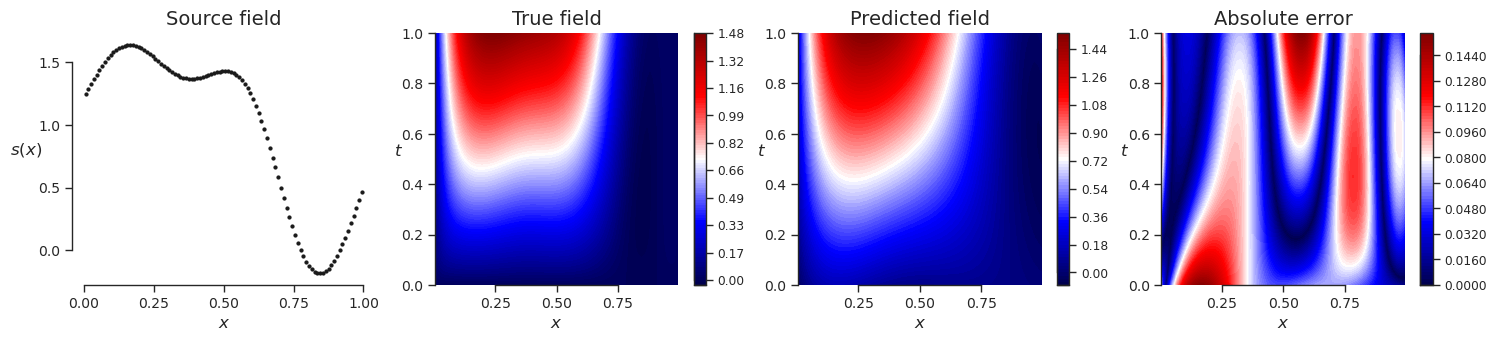

######################################################################################################################################################################################################################################
TEST SAMPLE 350
Rel. L2 Error = 0.2145, R2 score = 0.9506


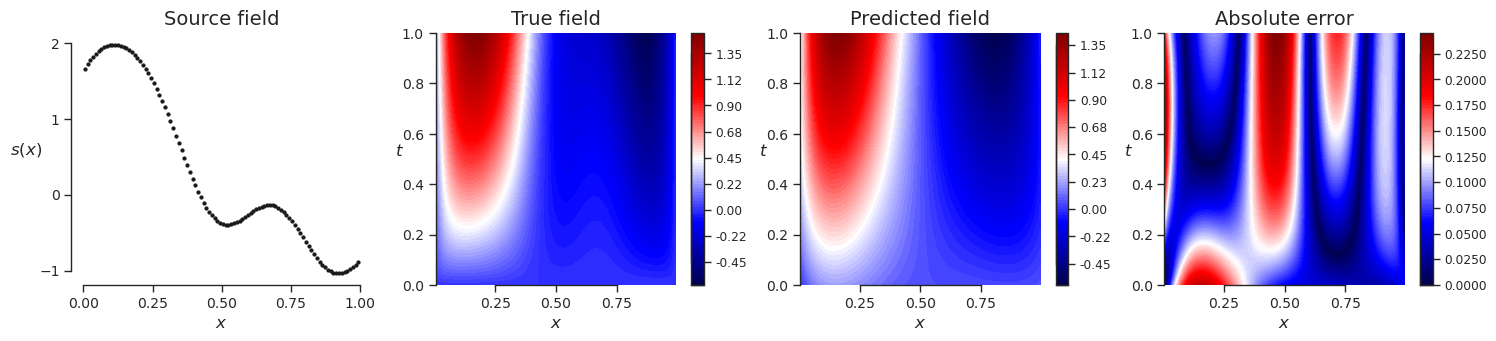

######################################################################################################################################################################################################################################
TEST SAMPLE 360
Rel. L2 Error = 0.1122, R2 score = 0.9784


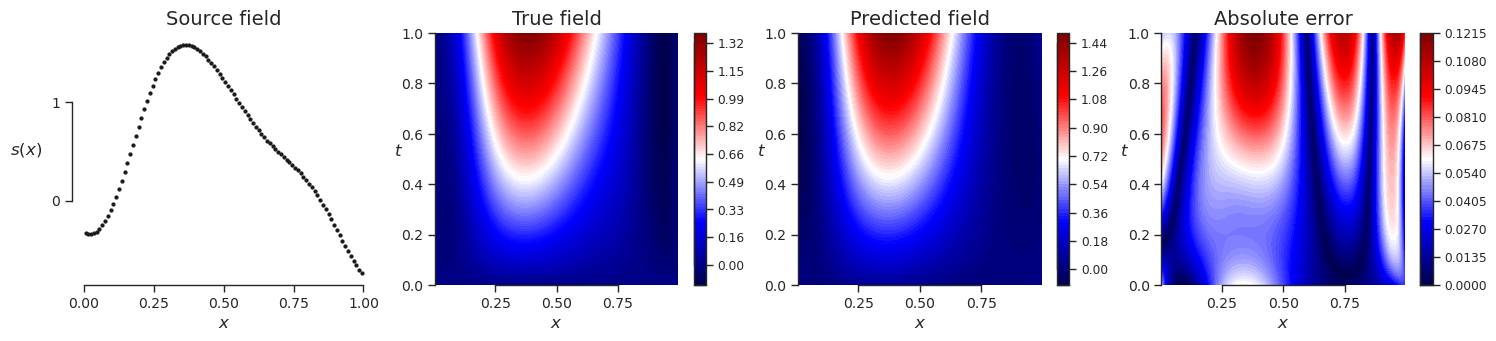

######################################################################################################################################################################################################################################
TEST SAMPLE 370
Rel. L2 Error = 0.2043, R2 score = 0.9542


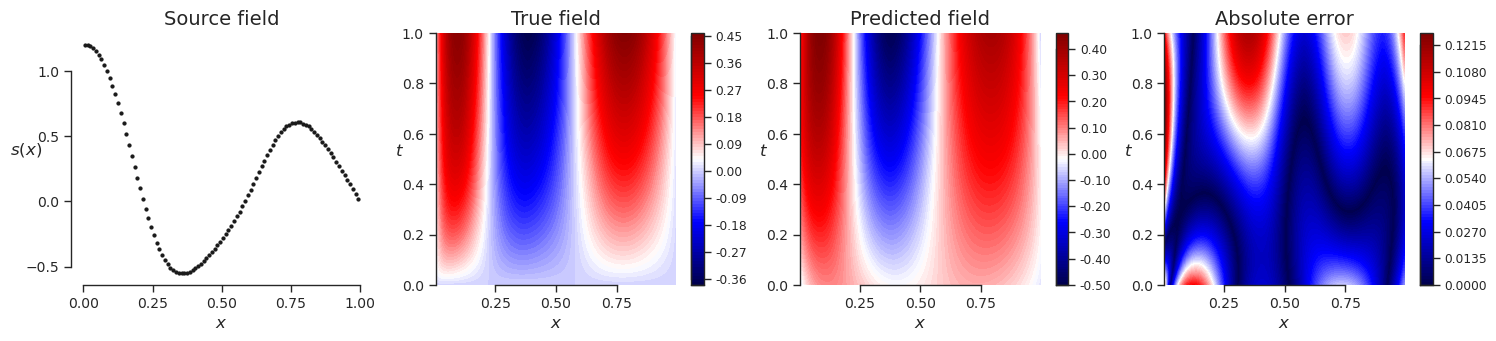

######################################################################################################################################################################################################################################
TEST SAMPLE 380
Rel. L2 Error = 0.3199, R2 score = 0.8838


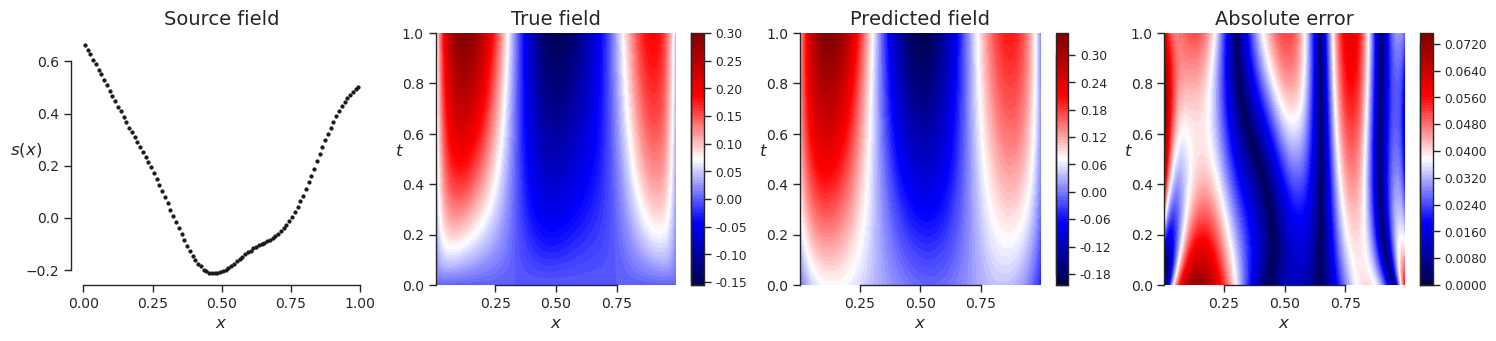

######################################################################################################################################################################################################################################
TEST SAMPLE 390
Rel. L2 Error = 0.2197, R2 score = 0.8503


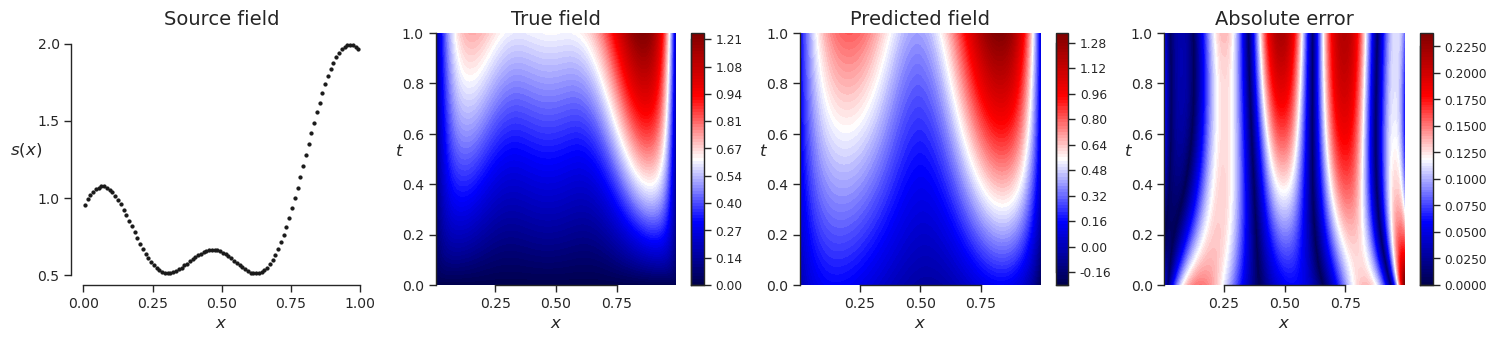

######################################################################################################################################################################################################################################
TEST SAMPLE 400
Rel. L2 Error = 0.1249, R2 score = 0.9733


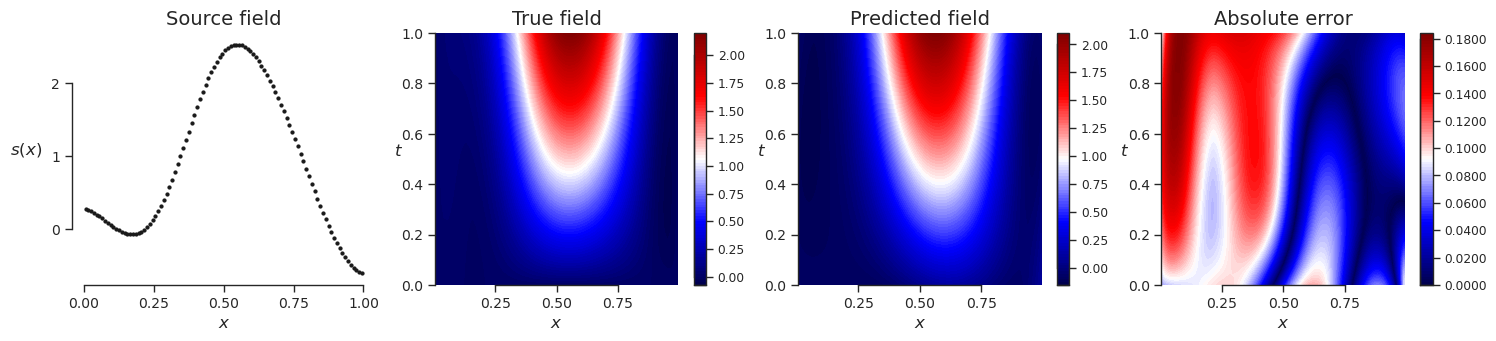

######################################################################################################################################################################################################################################
TEST SAMPLE 410
Rel. L2 Error = 0.16, R2 score = 0.9538


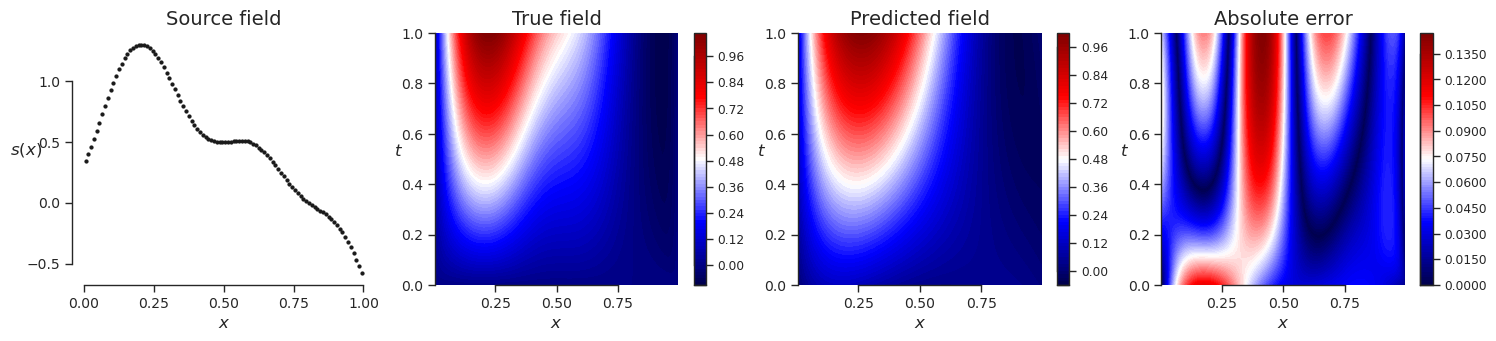

######################################################################################################################################################################################################################################
TEST SAMPLE 420
Rel. L2 Error = 0.3392, R2 score = 0.8672


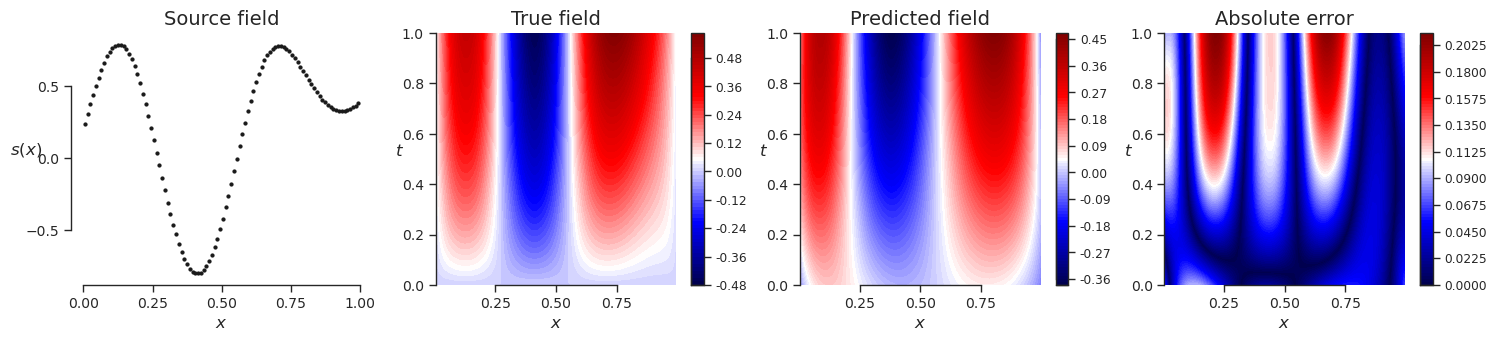

######################################################################################################################################################################################################################################
TEST SAMPLE 430
Rel. L2 Error = 0.0808, R2 score = 0.9791


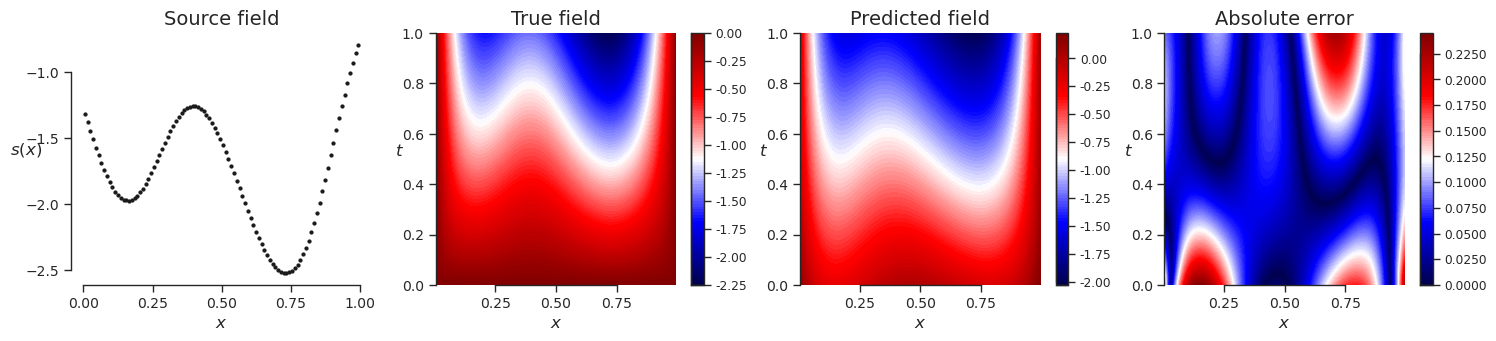

######################################################################################################################################################################################################################################
TEST SAMPLE 440
Rel. L2 Error = 0.1474, R2 score = 0.9401


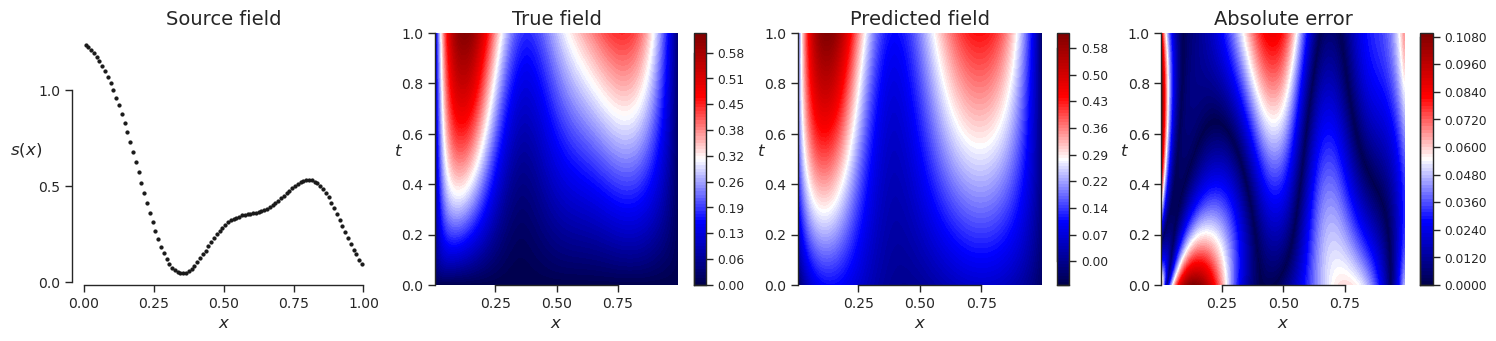

######################################################################################################################################################################################################################################
TEST SAMPLE 450
Rel. L2 Error = 0.1871, R2 score = 0.9429


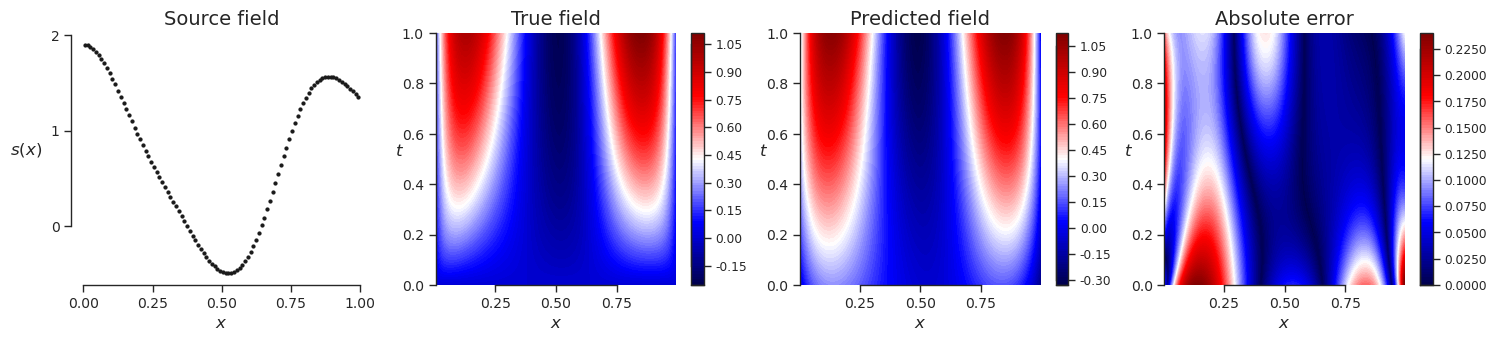

######################################################################################################################################################################################################################################
TEST SAMPLE 460
Rel. L2 Error = 0.3104, R2 score = 0.9024


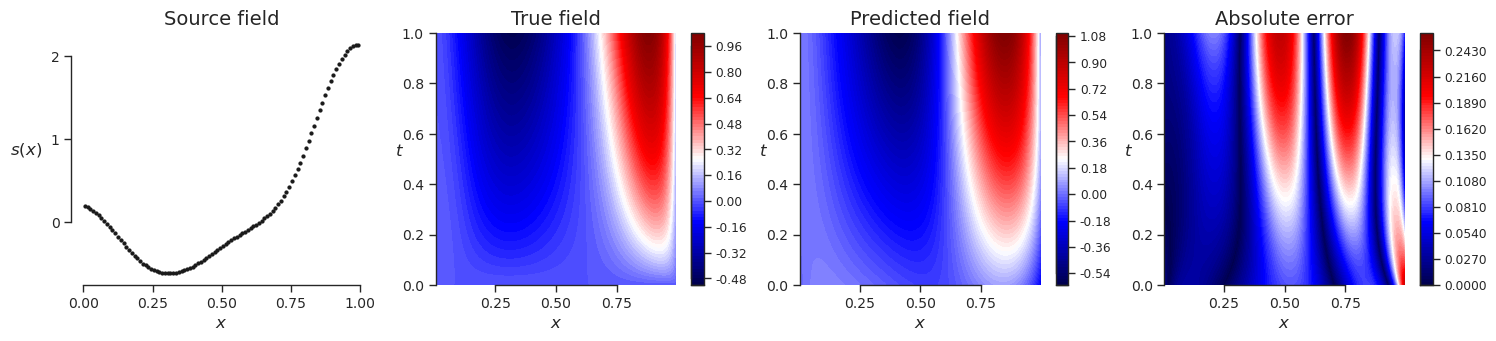

######################################################################################################################################################################################################################################
TEST SAMPLE 470
Rel. L2 Error = 0.1968, R2 score = 0.9073


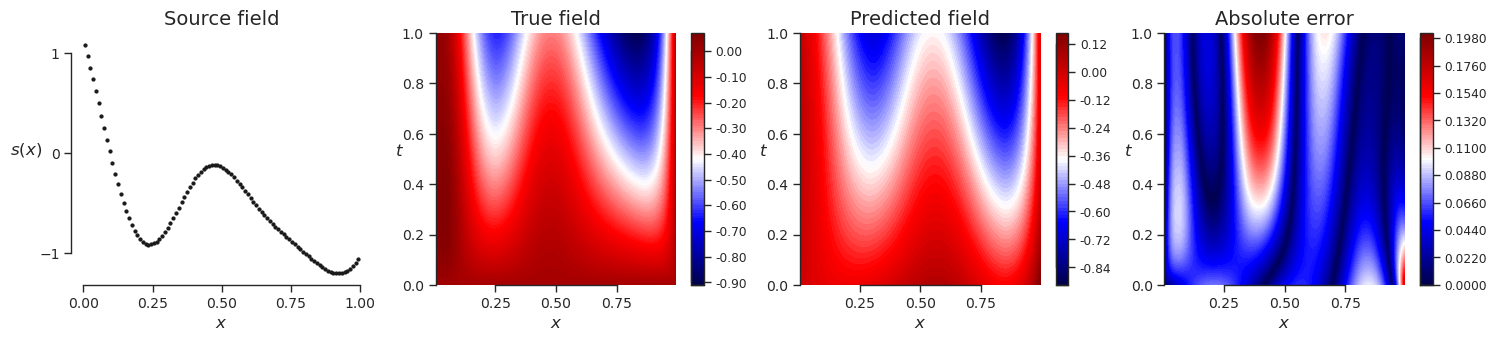

######################################################################################################################################################################################################################################
TEST SAMPLE 480
Rel. L2 Error = 0.231, R2 score = 0.9382


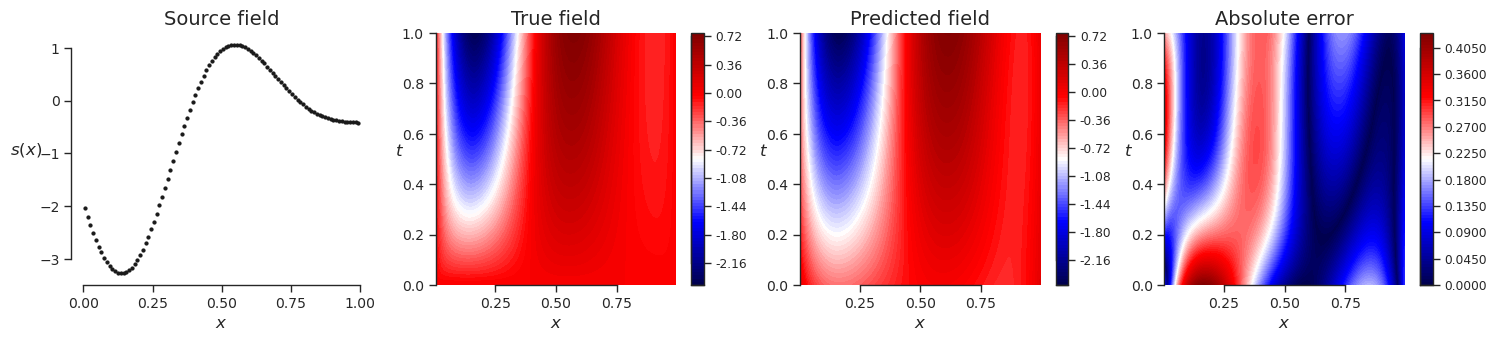

######################################################################################################################################################################################################################################
TEST SAMPLE 490
Rel. L2 Error = 0.2406, R2 score = 0.935


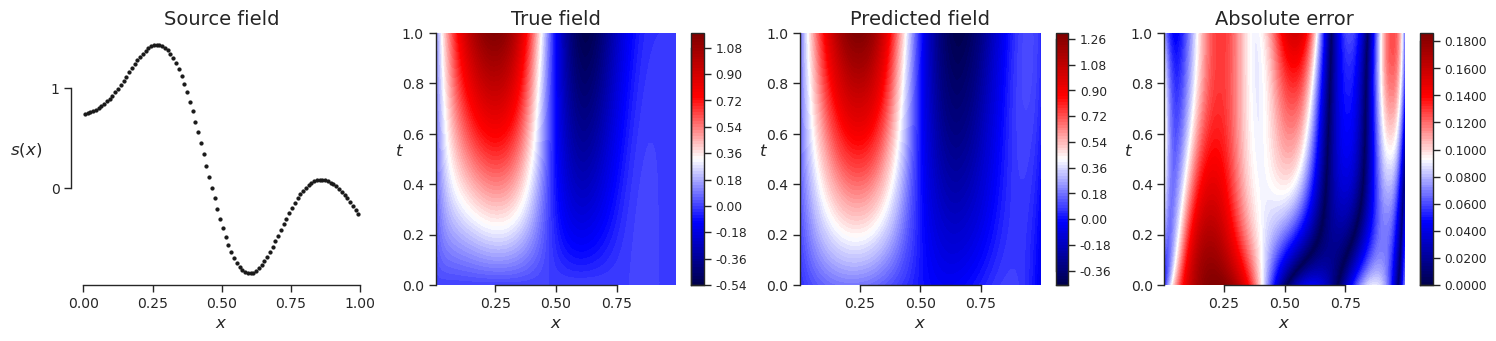

######################################################################################################################################################################################################################################
TEST SAMPLE 500
Rel. L2 Error = 0.2913, R2 score = 0.9144


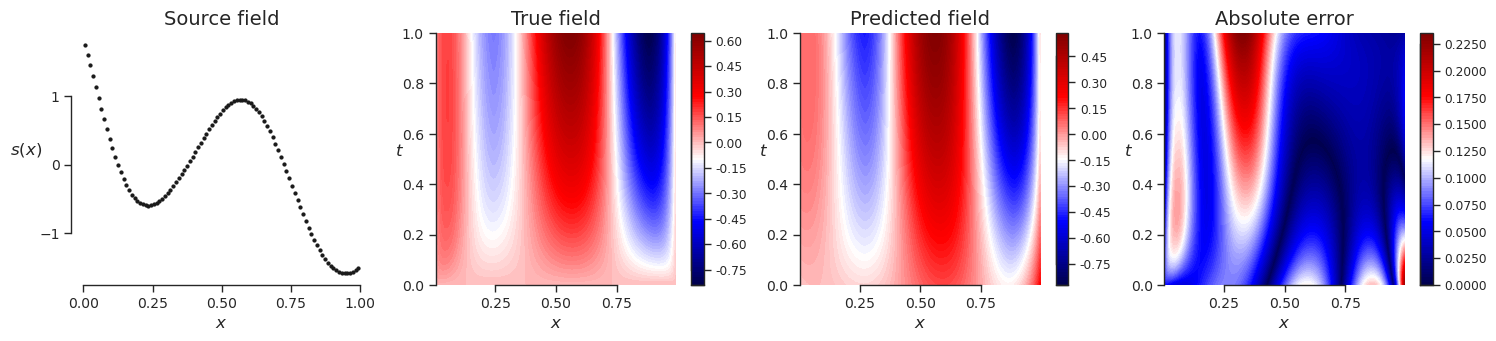

######################################################################################################################################################################################################################################
Mean Squared Error Test:
 0.006768323054595384
R2 score Test:
 0.9311175128910727
Rel. L2 Error Test:
 0.19638080076873302


In [19]:
# Predictions
branch_inputs = inputs_test # (bs, m) = (bs, nx) 
trunk_inputs = grid # (neval, 2) = (nt*nx, 2)
predictions_test = model(branch_inputs, trunk_inputs) # (bs, neval) = (bs, nt*nx)

mse_list, r2score_list, relerror_list = [], [], []

for i in range(inputs_test.shape[0]):

    prediction_i = predictions_test[i].reshape(1, -1) # (1, nt*nx)
    target_i = outputs_test[i].reshape(1, -1) # (1, nt*nx)
    
    mse_i = F.mse_loss(prediction_i.cpu(), target_i.cpu())
    r2score_i = metrics.r2_score(target_i.flatten().cpu().detach().numpy(), prediction_i.flatten().cpu().detach().numpy()) 
    relerror_i = np.linalg.norm(target_i.flatten().cpu().detach().numpy() - prediction_i.flatten().cpu().detach().numpy()) / np.linalg.norm(target_i.flatten().cpu().detach().numpy())
    
    mse_list.append(mse_i.item())
    r2score_list.append(r2score_i.item())
    relerror_list.append(relerror_i.item())
    
    if (i+1) % 10 == 0:
        plot_predictions(i, resultdir, target_i, prediction_i, x_span, inputs_test, X, T, nt, nx, r'$s(x)$', 'Source field', 'seismic', save)

mse = sum(mse_list) / len(mse_list)
print("Mean Squared Error Test:\n", mse)
r2score = sum(r2score_list) / len(r2score_list)
print("R2 score Test:\n", r2score)
relerror = sum(relerror_list) / len(relerror_list)
print("Rel. L2 Error Test:\n", relerror)

In [20]:
test_dict = {
    "inputs_test": inputs_test.cpu(),
    "outputs_test": outputs_test.cpu(),
    "predictions_test": predictions_test.reshape(-1, nt, nx).cpu()
}
for key, value in test_dict.items():
    print(f"Shape of {key}: {value.shape}")
print(colored('#'*230, 'green'))

if save == True:
    torch.save(test_dict, os.path.join(resultdir,'test_dict.pth'))

Shape of inputs_test: torch.Size([500, 100])
Shape of outputs_test: torch.Size([500, 101, 100])
Shape of predictions_test: torch.Size([500, 101, 100])
######################################################################################################################################################################################################################################


In [21]:
performance_metrics(mse, r2score, relerror, training_time, runtime_per_iter, resultdir, save)
# GPU memory used
if device.type == "cuda":
    print(f"Memory used (in MB):\n{mem_used_MB:.2f}")

Mean Squared Error Test:
0.006768323054595384
R2 score Test:
0.9311175128910727
Rel. L2 Error Test:
0.19638080076873302
Training Time (in sec):
28.355336666107178
Runtime per Iteration (in sec/iter):
0.028
Memory used (in MB):
747.00
